# Comparison between observations and sea level projections 1

Uses older projections results that did not output percentiles but PDFs from which percentiles could be computed. It also performs analysis that are not reproduced in notebook number 2.

In [13]:
import sys
import importlib

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import linregress

import IPython.display

sys.path.append('/Users/dewilebars/Projects/SLBudget/code/')
import SeaLevelContrib as slc
sys.path.append('../code')
import func_misc as misc
import func_postpro as postpro

In [14]:
# For higher resolution images on retina display screens
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

In [15]:
importlib.reload(slc)
importlib.reload(postpro)

<module 'func_postpro' from '../code/func_postpro.py'>

In [43]:
# Report path to save figures in:
path_report = '../reports/CompObsProj_v1/Figures/'
path_slb = '/Users/dewilebars/Projects/SLBudget/outputs/'

In [17]:
def ds2df(ds,perc=3):
    '''Extract the time series of contributors from a sea level projection 
    xarray dataset and build a pandas dataframe. Inputs are a dataset and 
    the percentile to extract.'''
    df = pd.DataFrame()
    for idx, val in enumerate(ds.proc):
        df[str(val.values)] = ds['perc_ts'][idx,perc,:]

    df['time'] = ds.time
    df = df.set_index('time')
    return df

In [18]:
# Read the AR5 type local projections
#KNMI14_45_ds = xr.open_dataset('../outputs/OldProjections/SeaLevelPDF_KNMI14_rcp45.nc')
#KNMI14_85_ds = xr.open_dataset('../outputs/OldProjections/SeaLevelPDF_KNMI14_rcp85.nc') #/OldProjections
#KNMI14_LowPass_45_ds = xr.open_dataset('../outputs/OldProjections/SeaLevelPDF_KNMI14_LowPass_rcp45.nc')
#KNMI14_LowPass_85_ds = xr.open_dataset('../outputs/OldProjections/SeaLevelPDF_KNMI14_LowPass_rcp85.nc')

KNMI14_45_ds = xr.open_dataset('../outputs/SeaLevelPerc_KNMI14_rcp45.nc')
KNMI14_85_ds = xr.open_dataset('../outputs/SeaLevelPerc_KNMI14_rcp85.nc')
KNMI14_LowPass_45_ds = xr.open_dataset('../outputs/SeaLevelPerc_KNMI14_LowPass_rcp45.nc')
KNMI14_LowPass_85_ds = xr.open_dataset('../outputs/SeaLevelPerc_KNMI14_LowPass_rcp85.nc')
KNMI14_45_ds.proc.values

array(['Global steric', 'Local ocean', 'Inverse barometer', 'Glaciers',
       'Greenland SMB', 'Antarctic SMB', 'Landwater',
       'Antarctic dynamics', 'Greenland dynamics', 'sum anta.', 'Total'],
      dtype=object)

In [19]:
KNMI14_df = postpro.read_knmi14(add_subsidence=True)
KNMI14_df[:10]

,low_05,low_95,high_05,high_95,low_05_sub,low_95_sub,high_05_sub,high_95_sub
year,,,,,,,,
1995,-0.2826,0.3990,-0.2826,0.3990,-0.2826,0.3990,-0.2826,0.3990
1996,0.1787,0.7226,0.1814,0.7251,0.2237,0.7676,0.2264,0.7701
1997,0.3832,1.3960,0.5654,1.5800,0.4732,1.4860,0.6554,1.6700
1998,0.5978,1.6610,0.9111,1.9760,0.7328,1.7960,1.0461,2.1110
1999,0.6499,2.0520,1.2050,2.6090,0.8299,2.2320,1.3850,2.7890
2000,0.7580,2.6900,1.5490,3.4850,0.9830,2.9150,1.7740,3.7100
2001,0.8874,3.1510,1.6750,3.9430,1.1574,3.4210,1.9450,4.2130
2002,1.0880,3.6320,1.8020,4.3510,1.4030,3.9470,2.1170,4.6660
2003,1.3860,4.0530,2.0380,4.7080,1.7460,4.4130,2.3980,5.0680


In [20]:
tg_id = [20, 22, 23, 24, 25, 32]
tg_df = slc.tide_gauge_obs(tg_id, interp=True)
tg_df.iloc[-10:]


,20,22,23,24,25,32,Average
time,,,,,,,
2011,12.552201,16.075159,11.692308,14.103846,12.082692,11.604027,13.018372
2012,11.852201,16.075159,10.192308,12.503846,10.782692,11.004027,12.068372
2013,10.452201,14.475159,7.292308,10.103846,6.482692,8.604027,9.568372
2014,14.252201,17.575159,10.592308,14.503846,11.782692,13.304027,13.668372
2015,14.552201,18.375159,13.592308,19.803846,16.482692,14.704027,16.251706
2016,14.852201,18.575159,11.692308,16.303846,12.782692,14.004027,14.701706
2017,16.452201,20.775159,15.592308,22.103846,17.382692,17.004027,18.218372
2018,11.952201,14.975159,8.892308,12.403846,7.182692,10.204027,10.935039
2019,16.952201,21.275159,17.092308,21.403846,16.482692,14.304027,17.918372


In [21]:
# Compute the linear trend from the tide gauge observations
# for each individual tide gauges
def print_lin_trend(tg_df, start_y, end_y):
    lin_trend = np.polyfit(np.arange(start_y,end_y+1), 
                           tg_df.loc[start_y:end_y], 1)[0,:]
    print('Linear trend for period '+str(start_y)+'-'+str(end_y))
    print(lin_trend)
    
print_lin_trend(tg_df, 1993, 2016)
print_lin_trend(tg_df, 1993, 2017)
print_lin_trend(tg_df, 1993, 2018)
print_lin_trend(tg_df, 1993, 2019)

Linear trend for period 1993-2016
[0.30530435 0.245      0.17369565 0.27634783 0.36721739 0.19543478
 0.2605    ]
Linear trend for period 1993-2017
[0.31684615 0.26846154 0.20915385 0.33861538 0.40546154 0.22592308
 0.29407692]
Linear trend for period 1993-2018
[0.28475214 0.23504274 0.17798291 0.30177778 0.34488889 0.18984615
 0.2557151 ]
Linear trend for period 1993-2019
[0.2967033  0.25665446 0.21691087 0.34157509 0.36788767 0.19224664
 0.278663  ]


In [22]:
# Compute the linear trend from the tide gauge observations
# with standard error
def print_lin_trend(tg_df, start_y, end_y):
    tg_df = tg_df*10 # Convert from cm to mm
    lin_trend = linregress(np.arange(start_y,end_y+1), 
                           tg_df.loc[start_y:end_y].Average)
    print(f'Linear trend for period (mm/y){str(start_y)}-{str(end_y)} and '+
          'standard error')
    print(f'{round(lin_trend.slope,1)}, {round(lin_trend.stderr,1)}')
    
print_lin_trend(tg_df, 1993, 2016)
print_lin_trend(tg_df, 1993, 2017)
print_lin_trend(tg_df, 1993, 2018)
print_lin_trend(tg_df, 1993, 2019)
print_lin_trend(tg_df, 1993, 2020)

Linear trend for period (mm/y)1993-2016 and standard error
2.6, 0.9
Linear trend for period (mm/y)1993-2017 and standard error
2.9, 0.9
Linear trend for period (mm/y)1993-2018 and standard error
2.6, 0.8
Linear trend for period (mm/y)1993-2019 and standard error
2.8, 0.8
Linear trend for period (mm/y)1993-2020 and standard error
3.0, 0.7


The numbers above clearly show that the trend is highly sensitive to the period of computation.

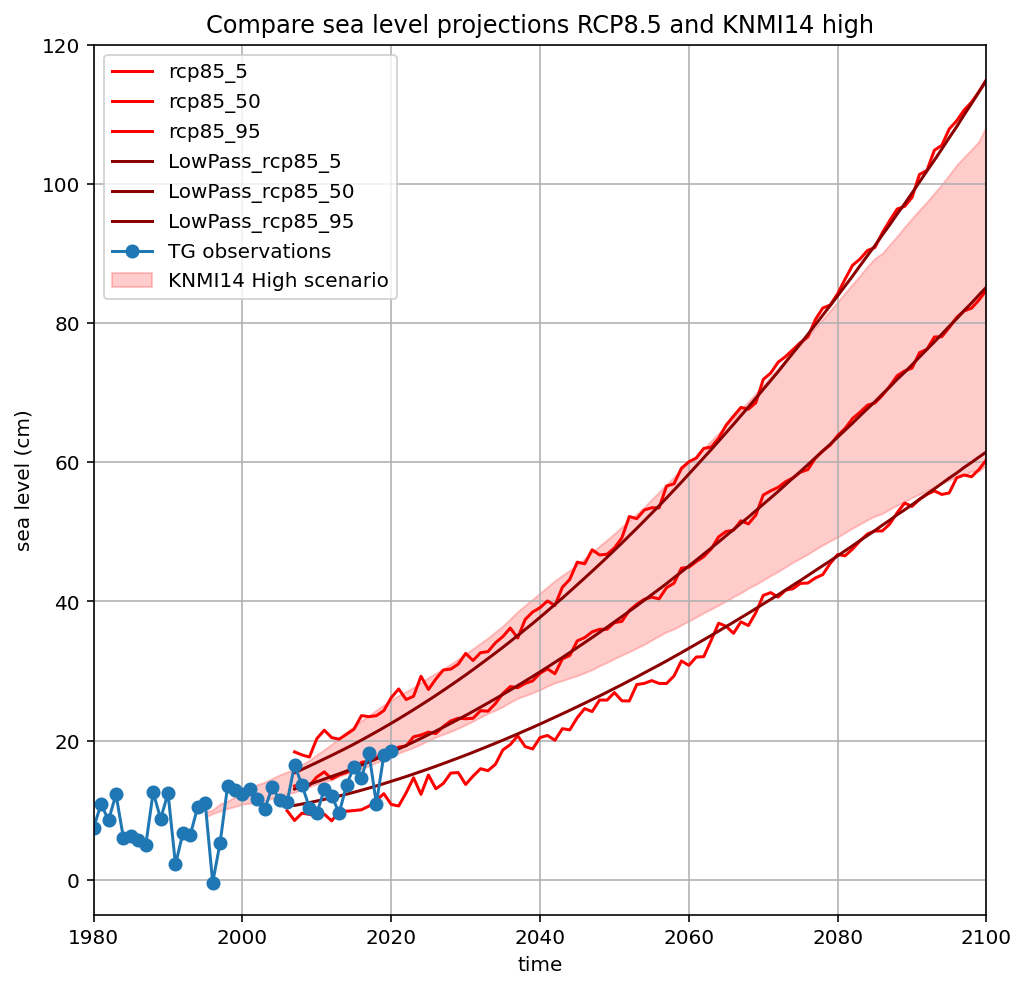

In [23]:
ref_KNMI14 = tg_df.loc[1986:2006].Average.mean() # 1980:2011
ref_RCP = tg_df.loc[1986:2006].Average.mean()

#Plot time series
fig, ax = plt.subplots(figsize=(8,8))
# ax.plot(KNMI14_df.iloc[:,2] + ref_KNMI14, 'r-', label=KNMI14_df.columns[2])
# ax.plot(KNMI14_df.iloc[:,3] + ref_KNMI14, 'r-', label=KNMI14_df.columns[3])

ax.fill_between(KNMI14_df.index, KNMI14_df['high_05'] + ref_KNMI14, 
                KNMI14_df['high_95'] + ref_KNMI14, color='red',alpha=0.2,
               label='KNMI14 High scenario')

ax.plot(KNMI14_85_ds.time, KNMI14_85_ds.perc_ts[-1,1,:] + ref_RCP, 'r-', 
        label='rcp85_5')
ax.plot(KNMI14_85_ds.time, KNMI14_85_ds.perc_ts[-1,5,:] + ref_RCP, 'r-', 
        label='rcp85_50')
ax.plot(KNMI14_85_ds.time, KNMI14_85_ds.perc_ts[-1,9,:] + ref_RCP, 'r-', 
        label='rcp85_95')

ax.plot(KNMI14_LowPass_85_ds.time, KNMI14_LowPass_85_ds.perc_ts[-1,1,:] + ref_RCP, 'darkred', 
        label='LowPass_rcp85_5')
ax.plot(KNMI14_LowPass_85_ds.time, KNMI14_LowPass_85_ds.perc_ts[-1,5,:] + ref_RCP, 'darkred', 
        label='LowPass_rcp85_50')
ax.plot(KNMI14_LowPass_85_ds.time, KNMI14_LowPass_85_ds.perc_ts[-1,9,:] + ref_RCP, 'darkred', 
        label='LowPass_rcp85_95')

ax.plot(tg_df['Average'], 'o-', label='TG observations')

#ax.set_aspect(1)
ax.set_xlim([1980,2100])
ax.set_ylim([-5,120])
plt.xlabel('time')
plt.ylabel('sea level (cm)')
plt.title('Compare sea level projections RCP8.5 and KNMI14 high')
ax.grid(True)
plt.legend(loc='upper left')

#plt.savefig('../figures/CompObsKNMI14_LowPass_high_RCP85.pdf', dpi=150)

<AxesSubplot:>

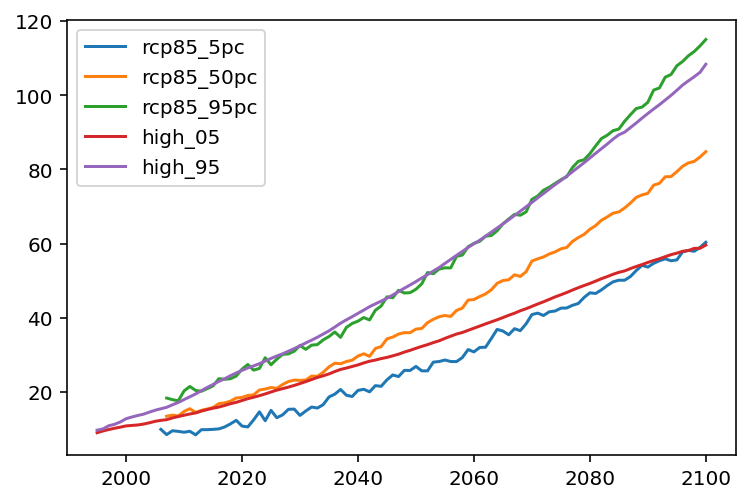

In [24]:
# Export data for Fedor:
SCE = 'rcp85'
KNMI_sce = 'high'
comp_KNMI14_rcp_df = pd.concat([ds2df(KNMI14_85_ds,1)['Total'], ds2df(KNMI14_85_ds,5)['Total'], 
                                ds2df(KNMI14_85_ds,9)['Total']], axis=1, join='outer')
comp_KNMI14_rcp_df.columns = [f'{SCE}_5pc', f'{SCE}_50pc', f'{SCE}_95pc']
comp_KNMI14_rcp_df = comp_KNMI14_rcp_df.join([KNMI14_df[f'{KNMI_sce}_05'], KNMI14_df[f'{KNMI_sce}_95']], how='outer')
comp_KNMI14_rcp_df = comp_KNMI14_rcp_df + ref_RCP
comp_KNMI14_rcp_df.plot()

#comp_KNMI14_rcp_df.to_csv('../outputs/DataKNMI14_rcp_DutchCoast.csv')

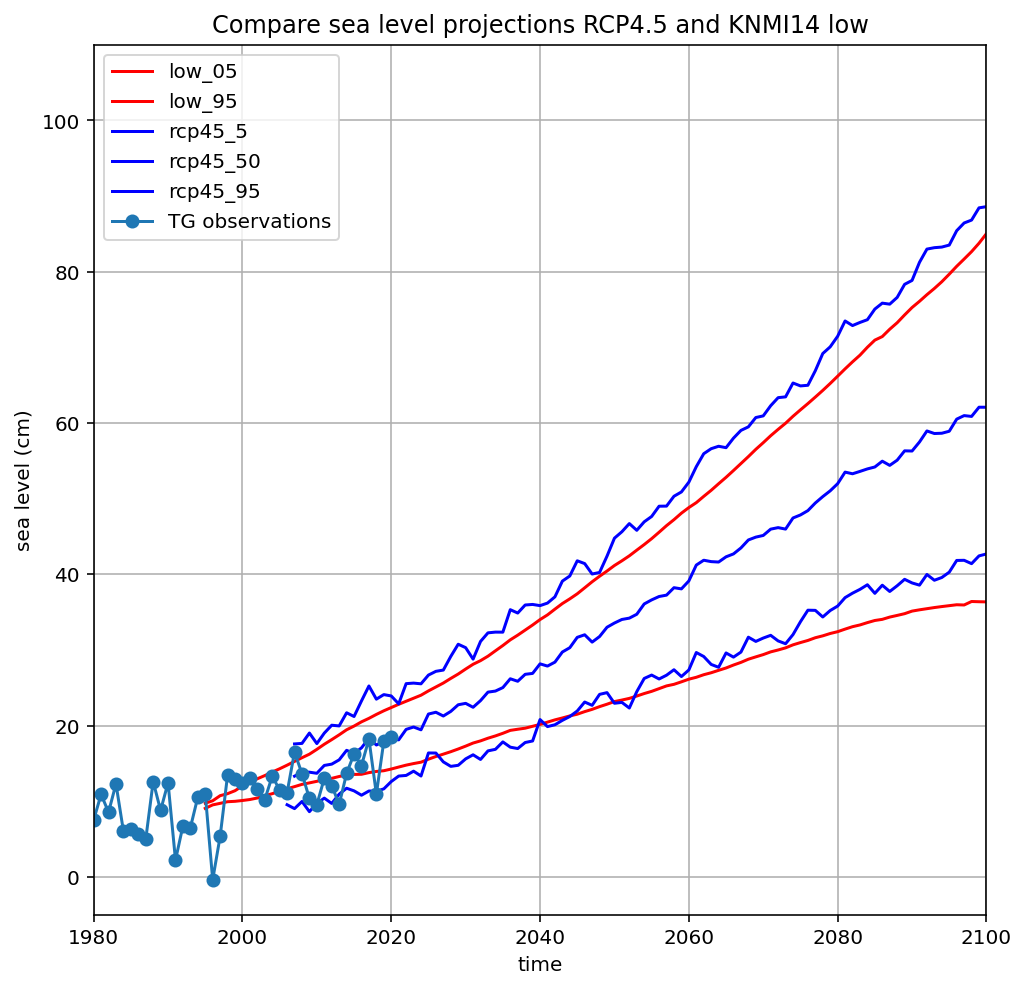

In [25]:
#Plot time series
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(KNMI14_df.iloc[:,0] + ref_KNMI14, 'r-', label=KNMI14_df.columns[0])
ax.plot(KNMI14_df.iloc[:,1] + ref_KNMI14, 'r-', label=KNMI14_df.columns[1])

ax.plot(KNMI14_45_ds.time, KNMI14_45_ds.perc_ts[-1,1,:] + ref_RCP, 'b-', 
        label='rcp45_5')
ax.plot(KNMI14_45_ds.time, KNMI14_45_ds.perc_ts[-1,5,:] + ref_RCP, 'b-', 
        label='rcp45_50')
ax.plot(KNMI14_45_ds.time, KNMI14_45_ds.perc_ts[-1,9,:] + ref_RCP, 'b-', 
        label='rcp45_95')
ax.plot(tg_df['Average'], 'o-', label='TG observations')

#ax.set_aspect(1)
ax.set_xlim([1980,2100])
ax.set_ylim([-5,110])
plt.xlabel('time')
plt.ylabel('sea level (cm)')
plt.title('Compare sea level projections RCP4.5 and KNMI14 low')
ax.grid(True)
plt.legend(loc='upper left')

#plt.savefig(path_report+'CompObsKNMI14_low_RCP45.pdf', dpi=150)

There is a clear difference between the KNMI'14 scenarios and the original RCP based scenarios from AR5. AR5 type local projections are accelerating more. And even though they reach similar numbers in 2100 the paths are rather different.

Possile causes:
- The temperature paths are piecewise linear, this could make them less curved
- The projections have a 30 years running average

### Impact of a 30 years running average

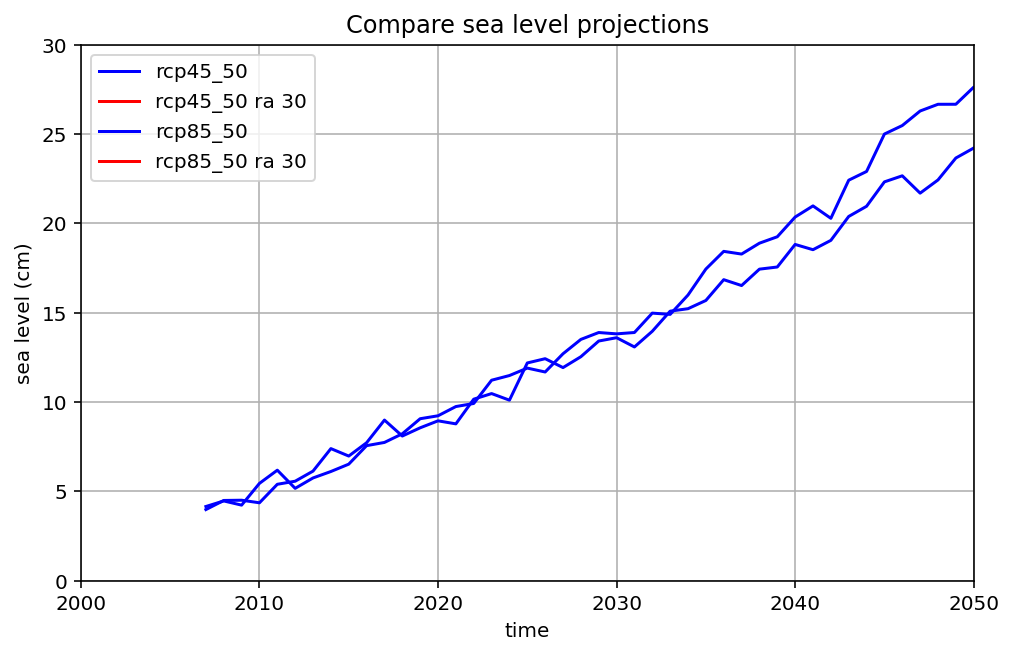

In [26]:
#Plot time series
fig, ax = plt.subplots(figsize=(8,8))

ax.plot(KNMI14_45_ds.time, KNMI14_45_ds.perc_ts[-1,5,:], 'b-', label='rcp45_50')
perc_ts_ra = KNMI14_45_ds.perc_ts.rolling(time=30, center=True).mean()
ax.plot(KNMI14_45_ds.time, perc_ts_ra[-1,5,:], 'r-', label='rcp45_50 ra 30')

ax.plot(KNMI14_85_ds.time, KNMI14_85_ds.perc_ts[-1,5,:], 'b-', label='rcp85_50')
perc_ts_ra = KNMI14_85_ds.perc_ts.rolling(time=30, center=True).mean()
ax.plot(KNMI14_85_ds.time, perc_ts_ra[-1,5,:], 'r-', label='rcp85_50 ra 30')

ax.set_aspect(1)
ax.set_xlim([2000,2050])
ax.set_ylim([0,30])
plt.xlabel('time')
plt.ylabel('sea level (cm)')
plt.title('Compare sea level projections')
ax.grid(True)
plt.legend(loc='upper left')

#plt.savefig(path_report+'ImpactOf30yrRunningAverage.pdf', dpi=150)

This shows that applying a final 30 years running average doesn't influence the results much. But maybe applying the running average to each component before adding everything up has a bigger effect? -> To check

### Check Sybren's idea that starting the projection from a trend that uses a break point in 1993 is better than using a simple linear trend
Conclusions is that it doesn't matter much which assumption is made on the trend (linear or break point)

In [27]:
# define the statistical models
def linear_model(df, with_nodaltides=False, with_wind=False, with_ar=False):
    y = df['Average']
    X = np.c_[
        df['year']-1970, 
    ]
    month = np.mod(df['year'], 1) * 12.0
    names = ['Constant', 'Trend']
    if with_nodaltides:
        X = np.c_[
            X,
            np.cos(2*np.pi*(df['year']-1970)/18.613),
            np.sin(2*np.pi*(df['year']-1970)/18.613)
        ]
        names.extend(['Nodal U', 'Nodal V'])
    if with_wind:
        X = np.c_[
            X, 
            df['u2'],
            df['v2']
        ]
        names.extend(['Wind $u^2$', 'Wind $v^2$'])
    X = sm.add_constant(X)
    if with_ar:
        model = sm.GLSAR(y, X, missing='drop', rho=1)
    else:
        model = sm.OLS(y, X, missing='drop')
    fit = model.fit(cov_type='HC0')
    return fit, names

def broken_linear_model(df, with_nodaltides=False, with_wind=False):
    """This model fits the sea-level rise has started to rise faster in 1993."""
    y = df['Average']
    X = np.c_[
        df['year']-1970, 
        (df['year'] > 1993) * (df['year'] - 1993)
    ]
    names = ['Constant', 'Trend', '+trend (1993)']
    
    if with_nodaltides:
        X = np.c_[
            X,
            np.cos(2*np.pi*(df['year']-1970)/18.613),
            np.sin(2*np.pi*(df['year']-1970)/18.613)
        ]
        names.extend(['Nodal U', 'Nodal V'])
    
    if with_wind:
        X = np.c_[
            X, 
            df['u2'],
            df['v2']
        ]
        names.extend(['Wind $u^2$', 'Wind $v^2$'])
    X = sm.add_constant(X)
    model_broken_linear = sm.GLSAR(y, X, rho=1)
    fit = model_broken_linear.iterative_fit(cov_type='HC0')
    return fit, names

tg_df_sel = tg_df.loc[1890:].copy()
tg_df_sel['year'] = tg_df_sel.index

linear_fit, names = linear_model(tg_df_sel)
broken_linear_fit, broken_names = broken_linear_model(tg_df_sel)

tg_df_sel['linear_fit'] = linear_fit.predict()
tg_df_sel['broken_line_fit'] = broken_linear_fit.predict()

tg_df_sel.loc[2000:]

,20,22,23,24,25,32,Average,year,linear_fit,broken_line_fit
time,,,,,,,,,,
2000,10.852201,15.775159,11.092308,13.603846,10.182692,12.904027,12.401706,2000,10.382645,10.263298
2001,12.752201,17.575159,10.992308,14.503846,9.182692,13.604027,13.101706,2001,10.574551,10.552294
2002,11.052201,16.075159,9.792308,12.503846,7.782692,12.504027,11.618372,2002,10.766457,10.841290
2003,10.052201,13.875159,8.792308,10.503846,6.382692,11.604027,10.201706,2003,10.958363,11.130286
2004,13.252201,16.175159,11.992308,13.503846,11.282692,13.504027,13.285039,2004,11.150269,11.419282
2005,14.552201,14.975159,9.292308,10.003846,8.282692,11.904027,11.501706,2005,11.342175,11.708278
2006,11.952201,14.675159,9.492308,9.903846,8.982692,11.804027,11.135039,2006,11.534081,11.997274
2007,16.452201,19.575159,14.192308,17.403846,14.682692,16.604027,16.485039,2007,11.725987,12.286270
2008,13.752201,16.675159,11.692308,13.603846,12.282692,13.804027,13.635039,2008,11.917893,12.575267


In [28]:
# summary of the linear model
table = linear_fit.summary(yname='Sea-surface height', 
                           xname=names, 
                           title='Linear model (1890-current)')
IPython.display.display(table)

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Linear model (1890-current)                          
==============================================================================
Dep. Variable:     Sea-surface height   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     787.5
Date:                Fri, 25 Mar 2022   Prob (F-statistic):           9.00e-57
Time:                        12:18:24   Log-Likelihood:                -331.89
No. Observations:                 131   AIC:                             667.8
Df Residuals:                     129   BIC:                             673.5
Df Model:                           1                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Constant       4.6255      0.299     15.473      0.000       4.040       5.211
Trend          0.1919      0.007     28.062      0.000       0.179       0.205
==============================================================================
Omnibus:                        4.044   Durbin-Watson:                   1.554
Prob(Omnibus):                  0.132   Jarque-Bera (JB):                3.660
Skew:                          -0.404   Prob(JB):                        0.160
Kurtosis:                       3.129   Cond. No.                         43.8
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

In [29]:
# summary of the broken linear model
print('rho=%s' % broken_linear_fit.history['rho'][-1])
IPython.display.display(broken_linear_fit.summary(yname='Sea-surface height', 
                                                  xname=broken_names))

rho=[0.1963996]


<class 'statsmodels.iolib.summary.Summary'>
"""
                           GLSAR Regression Results                           
==============================================================================
Dep. Variable:     Sea-surface height   R-squared:                       0.794
Model:                          GLSAR   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                     276.4
Date:                Fri, 25 Mar 2022   Prob (F-statistic):           5.43e-47
Time:                        12:18:25   Log-Likelihood:                -325.06
No. Observations:                 130   AIC:                             656.1
Df Residuals:                     127   BIC:                             664.7
Df Model:                           2                                         
Covariance Type:                  HC0                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Constant          4.1333      0.510      8.101      0.000       3.133       5.133
Trend             0.1786      0.012     14.889      0.000       0.155       0.202
+trend (1993)     0.1104      0.065      1.708      0.088      -0.016       0.237
==============================================================================
Omnibus:                        3.337   Durbin-Watson:                   1.938
Prob(Omnibus):                  0.189   Jarque-Bera (JB):                2.833
Skew:                          -0.343   Prob(JB):                        0.243
Kurtosis:                       3.231   Cond. No.                         56.4
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

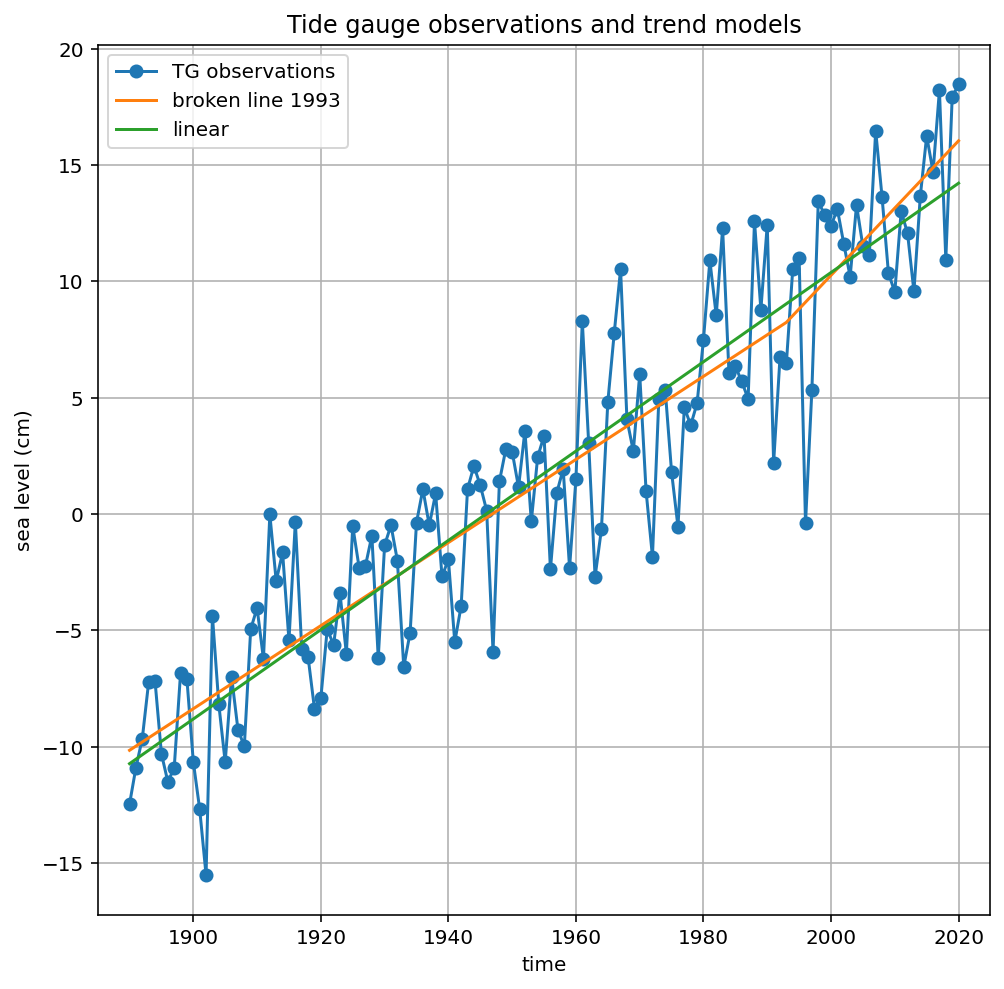

In [47]:
#Plot time series
fig, ax = plt.subplots(figsize=(8,8))

ax.plot(tg_df['Average'].loc[1890:], 'o-', label='TG observations')
ax.plot(tg_df_sel['year'], broken_linear_fit.predict(), label='broken line 1993')
ax.plot(tg_df_sel['year'], linear_fit.predict(), label='linear')

#ax.set_aspect(1)
ax.set_xlim([1885,2025])
#ax.set_ylim([-5,40])
plt.xlabel('time')
plt.ylabel('sea level (cm)')
plt.title('Tide gauge observations and trend models')
ax.grid(True)
plt.legend(loc='upper left')

#plt.savefig('../figures/TideGaugeObsTrend.pdf', dpi=150)

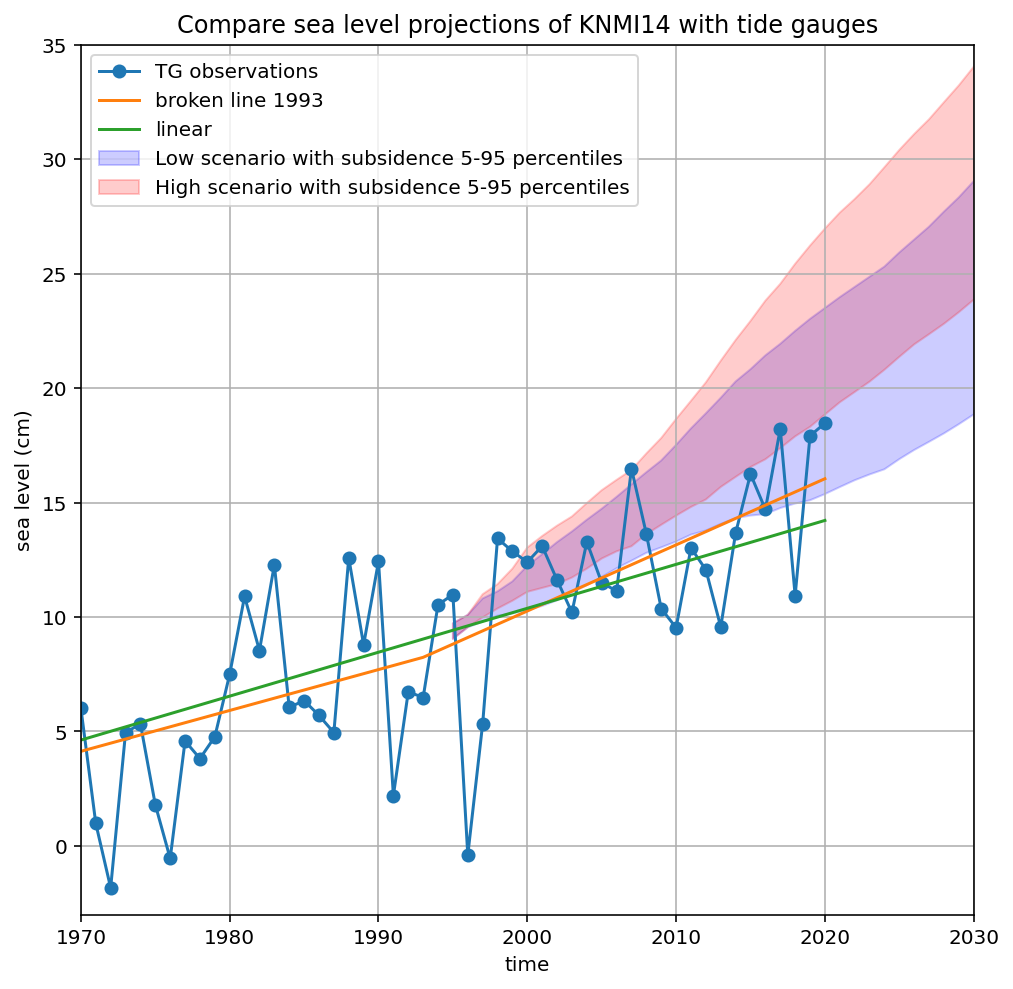

In [52]:
ref_KNMI14_blm = tg_df_sel.loc[1995]['broken_line_fit']

ref = ref_KNMI14

#Plot time series
fig, ax = plt.subplots(figsize=(8,8))
ax.fill_between(KNMI14_df.index, KNMI14_df['low_05_sub'] + ref, 
                KNMI14_df['low_95_sub'] + ref, color='blue',alpha=0.2,
               label='Low scenario with subsidence 5-95 percentiles')
ax.fill_between(KNMI14_df.index, KNMI14_df['high_05_sub'] + ref, 
                KNMI14_df['high_95_sub'] + ref, color='red',alpha=0.2,
               label='High scenario with subsidence 5-95 percentiles')
ax.plot(tg_df['Average'], 'o-', label='TG observations')
ax.plot(tg_df_sel['year'], broken_linear_fit.predict(), label='broken line 1993')
ax.plot(tg_df_sel['year'], linear_fit.predict(), label='linear')


#ax.set_aspect(1)
ax.set_xlim([1970,2030])
ax.set_ylim([-3,35])
plt.xlabel('time')
plt.ylabel('sea level (cm)')
plt.title('Compare sea level projections of KNMI14 with tide gauges')
ax.grid(True)
plt.legend(loc='upper left')

#plt.savefig('../figures/ComparisonTG_KNMI14_2.pdf', dpi=150)

### New comparison figure between KNMI'14 and tide gauge observations

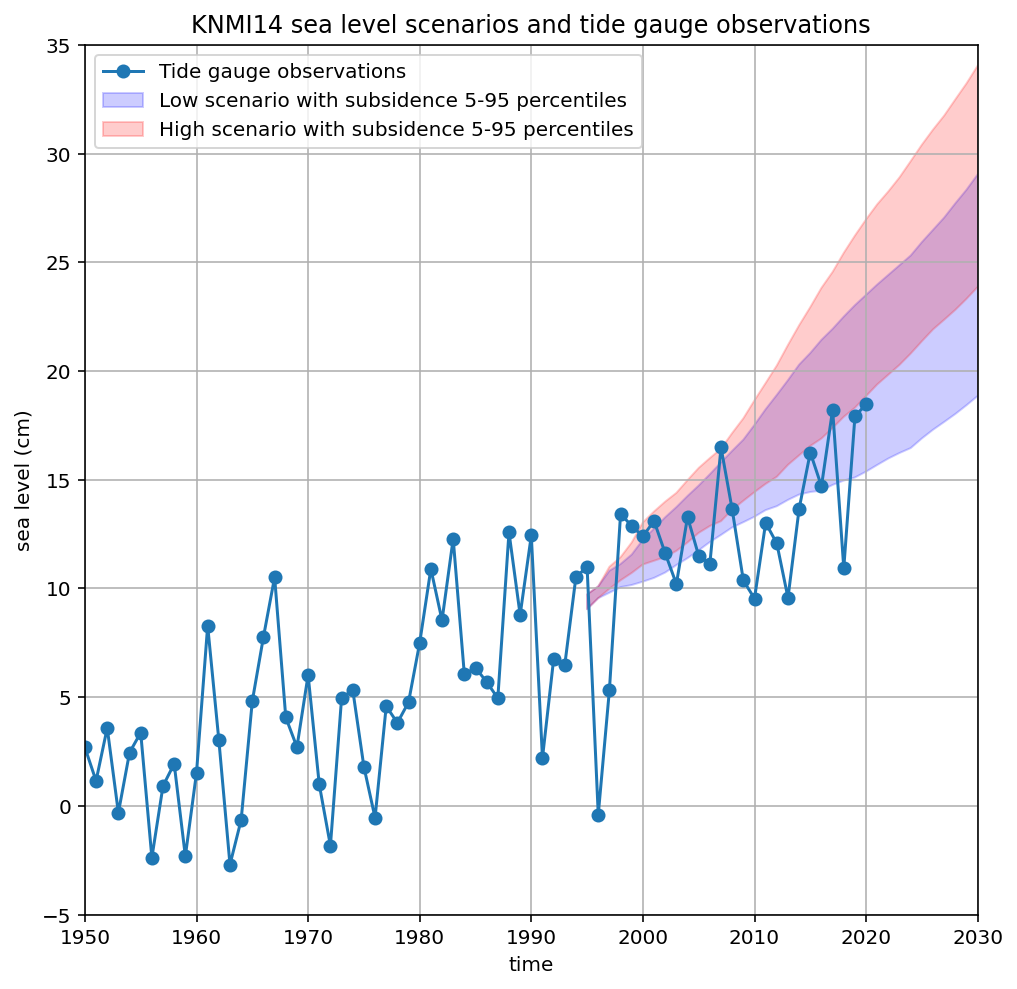

In [20]:
#Plot time series
fig, ax = plt.subplots(figsize=(8,8))
ax.fill_between(KNMI14_df.index, KNMI14_df['low_05_sub'] + ref_KNMI14, 
                KNMI14_df['low_95_sub'] + ref_KNMI14, color='blue',alpha=0.2,
               label='Low scenario with subsidence 5-95 percentiles')
ax.fill_between(KNMI14_df.index, KNMI14_df['high_05_sub'] + ref_KNMI14, 
                KNMI14_df['high_95_sub'] + ref_KNMI14, color='red',alpha=0.2,
               label='High scenario with subsidence 5-95 percentiles')
ax.plot(tg_df['Average'], 'o-', label='Tide gauge observations')

#ax.set_aspect(1)
ax.set_xlim([1950,2030])
ax.set_ylim([-5,35])
plt.xlabel('time')
plt.ylabel('sea level (cm)')
plt.title('KNMI14 sea level scenarios and tide gauge observations')
ax.grid(True)
plt.legend(loc='upper left')

#plt.savefig(path_report+'ComparisonTG_KNMI14.pdf', dpi=150)

Add the running average of the observations

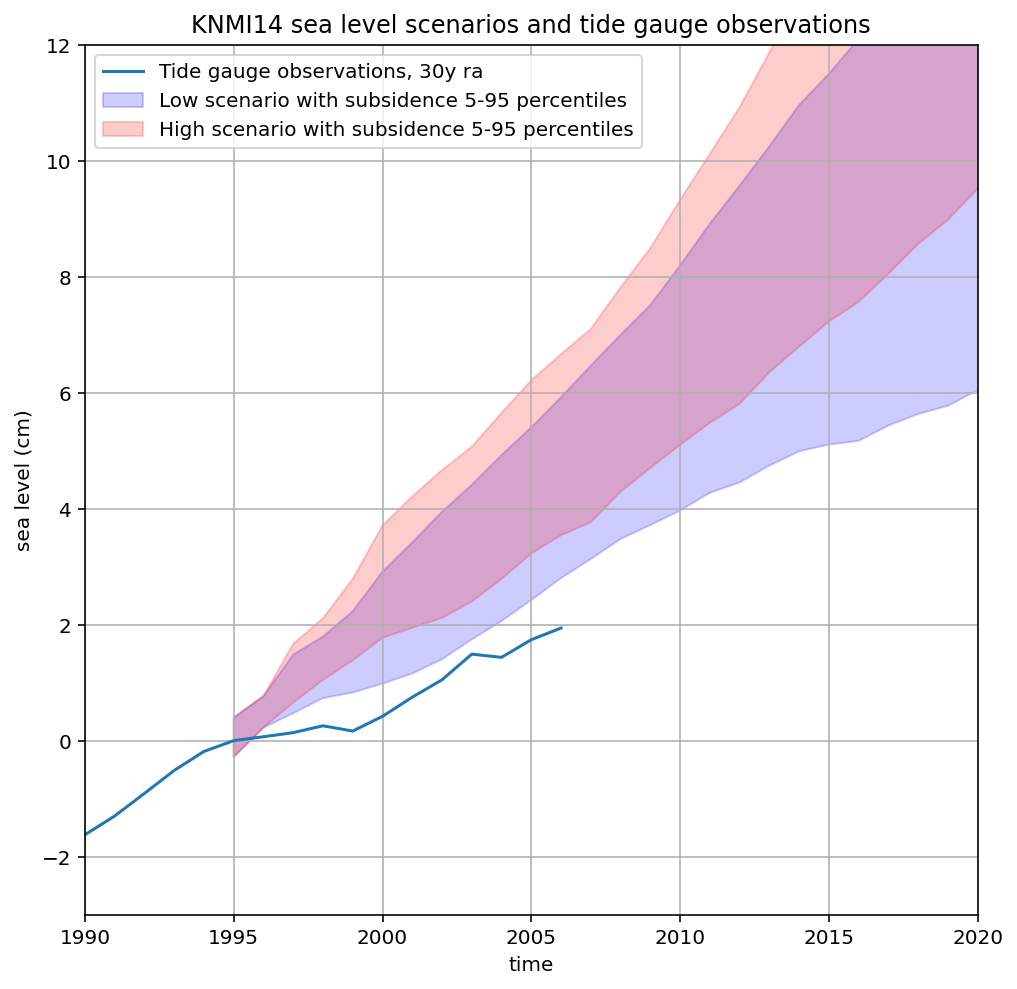

In [21]:
tg_avg_ra = tg_df['Average'].rolling(30, center=True).mean()
tg_avg_ra = tg_avg_ra - tg_avg_ra.loc[1995]

#Plot time series
fig, ax = plt.subplots(figsize=(8,8))
ax.fill_between(KNMI14_df.index, KNMI14_df['low_05_sub'] + tg_avg_ra.loc[1995], 
                KNMI14_df['low_95_sub'] + tg_avg_ra.loc[1995], color='blue',alpha=0.2,
               label='Low scenario with subsidence 5-95 percentiles')
ax.fill_between(KNMI14_df.index, KNMI14_df['high_05_sub'] + tg_avg_ra.loc[1995], 
                KNMI14_df['high_95_sub'] + tg_avg_ra.loc[1995], color='red',alpha=0.2,
               label='High scenario with subsidence 5-95 percentiles')

ax.plot(tg_avg_ra, '-', label='Tide gauge observations, 30y ra')

#ax.set_aspect(1)
#ax.set_xlim([1950,2030])
#ax.set_ylim([-5,35])
ax.set_xlim([1990,2020])
ax.set_ylim([-3,12])
plt.xlabel('time')
plt.ylabel('sea level (cm)')
plt.title('KNMI14 sea level scenarios and tide gauge observations')
ax.grid(True)
plt.legend(loc='upper left')

#plt.savefig(path_report+'RunningAverage_avg.pdf', dpi=150)

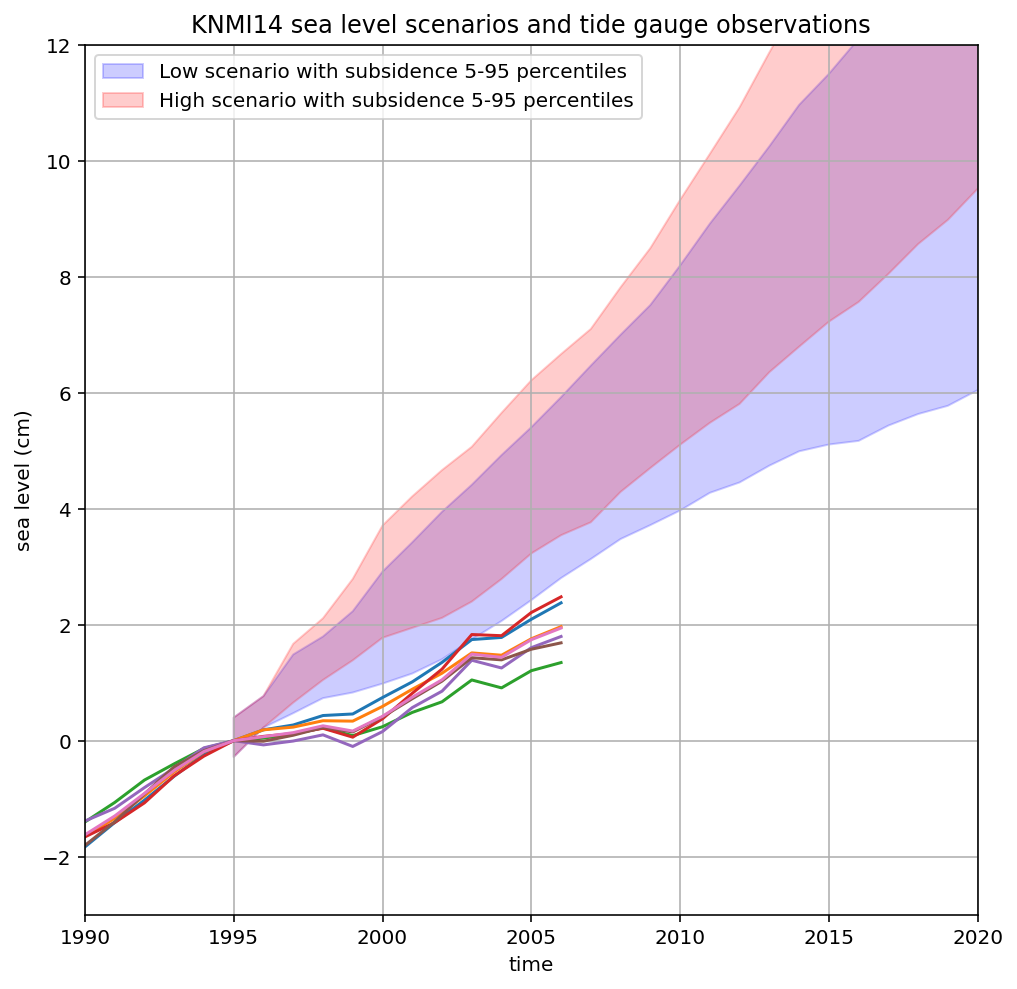

In [22]:
# Compare with individual tide gauges
tg_avg_ra = tg_df.rolling(30, center=True).mean()
tg_avg_ra = tg_avg_ra - tg_avg_ra.loc[1995]

#Plot time series
fig, ax = plt.subplots(figsize=(8,8))
ax.fill_between(KNMI14_df.index, KNMI14_df['low_05_sub'] 
                + tg_avg_ra['Average'].loc[1995], 
                KNMI14_df['low_95_sub'] + tg_avg_ra['Average'].loc[1995], 
                color='blue',alpha=0.2,
               label='Low scenario with subsidence 5-95 percentiles')
ax.fill_between(KNMI14_df.index, KNMI14_df['high_05_sub'] 
                + tg_avg_ra['Average'].loc[1995], 
                KNMI14_df['high_95_sub'] + tg_avg_ra['Average'].loc[1995], 
                color='red',alpha=0.2,
               label='High scenario with subsidence 5-95 percentiles')

ax.plot(tg_avg_ra, '-')

#ax.set_aspect(1)
#ax.set_xlim([1950,2030])
#ax.set_ylim([-5,35])
ax.set_xlim([1990,2020])
ax.set_ylim([-3,12])
plt.xlabel('time')
plt.ylabel('sea level (cm)')
plt.title('KNMI14 sea level scenarios and tide gauge observations')
ax.grid(True)
plt.legend(loc='upper left')

#plt.savefig(path_report+'RunningAverage_all.pdf', dpi=150)

This plot makes it clear that the projections are higher than the 30 years running average from the observations.

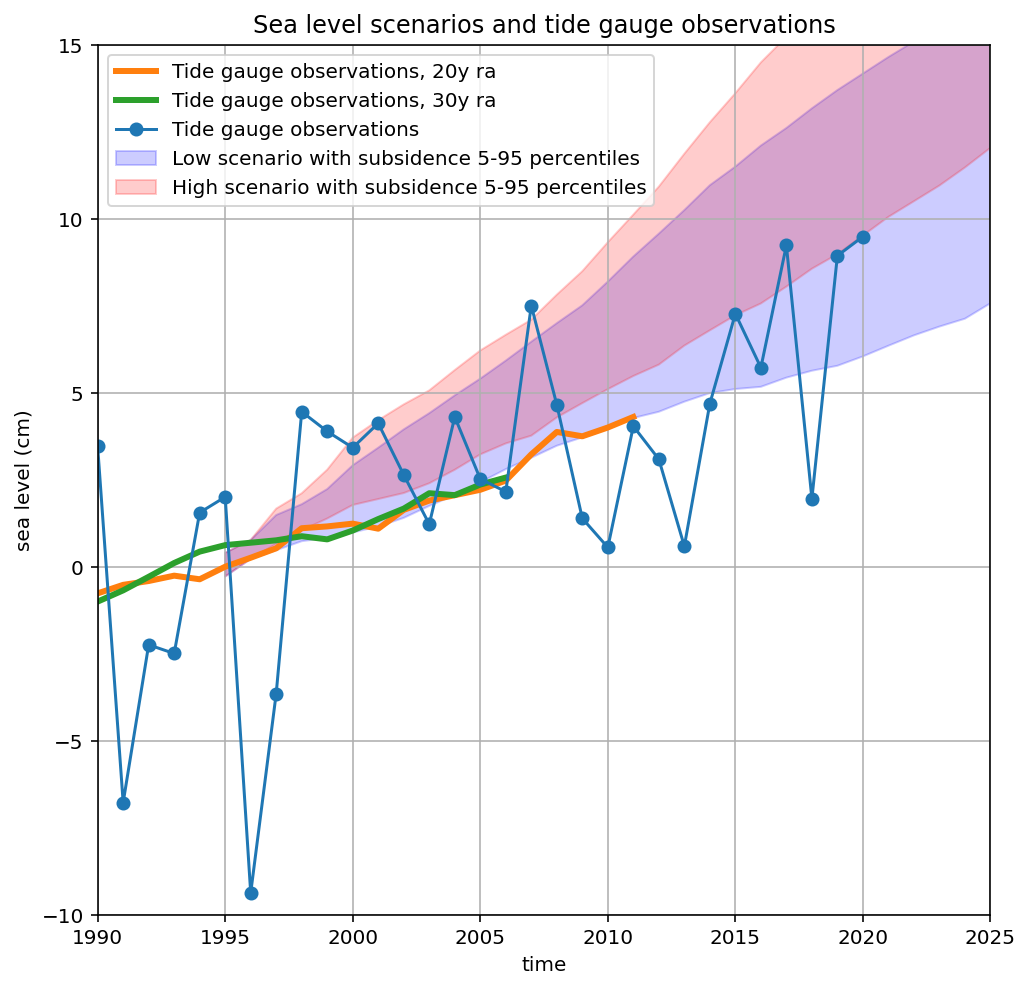

In [23]:
tg_avg_20ra = tg_df['Average'].rolling(20, center=True).mean()
tg_avg_30ra = tg_df['Average'].rolling(30, center=True).mean()
ref = tg_avg_20ra.loc[1995]

#Plot time series
fig, ax = plt.subplots(figsize=(8,8))
ax.fill_between(KNMI14_df.index, KNMI14_df['low_05_sub'], 
                KNMI14_df['low_95_sub'], color='blue',alpha=0.2,
               label='Low scenario with subsidence 5-95 percentiles')
ax.fill_between(KNMI14_df.index, KNMI14_df['high_05_sub'], 
                KNMI14_df['high_95_sub'], color='red',alpha=0.2,
               label='High scenario with subsidence 5-95 percentiles')

ax.plot(tg_avg_20ra - ref, '-', color='tab:orange', label='Tide gauge observations, 20y ra', linewidth=3)
ax.plot(tg_avg_30ra - ref, '-', color='tab:green', label='Tide gauge observations, 30y ra', linewidth=3)
ax.plot(tg_df['Average'] - ref, 'o-', color='tab:blue', label='Tide gauge observations')

#ax.set_aspect(1)
#ax.set_xlim([1950,2030])
#ax.set_ylim([-5,35])
ax.set_xlim([1990,2025])
ax.set_ylim([-10,15])
plt.xlabel('time')
plt.ylabel('sea level (cm)')
plt.title('Sea level scenarios and tide gauge observations')
ax.grid(True)
plt.legend(loc='upper left')

#plt.savefig(path_report+'rcp_not_better.pdf', dpi=150)
#plt.savefig('/Users/dewilebars/Documents/ConferencesLecturesTalks/2020_07_09_Vakgroepmeeting/KNMI14vsTG.pdf', dpi=150)

Based on this comparison it does seem like the projections where overestimated. This makes it even more important to find out.

### Look into the components of the KNMI'14 scenarios

In [24]:
path_KNMI14 = '/Users/dewilebars/Projects/Project_ProbSLR/KNMI14/'
# Info on the "level" index: 
# mean, p05, p10, p50, p90, p95, last column not used.
KNMI14_high_ds = xr.open_dataset(path_KNMI14 + 
                    '/ComponentInfo/ENS_knmi_NORTHSEA_slscen_high_V8.nc', 
                                 decode_times=False)
KNMI14_low_ds = xr.open_dataset(path_KNMI14 + 
                    '/ComponentInfo/ENS_knmi_NORTHSEA_slscen_low_V8.nc', 
                                decode_times=False)
KNMI14_high_ds['time'] = KNMI14_high_ds.time + 1950
KNMI14_low_ds['time'] = KNMI14_low_ds.time + 1950
KNMI14_high_ds

<xarray.Dataset>
Dimensions:  (lat: 1, lev: 7, lon: 1, time: 115)
Coordinates:
  * time     (time) float64 1.986e+03 1.987e+03 1.988e+03 ... 2.099e+03 2.1e+03
  * lon      (lon) float64 0.0
  * lat      (lat) float64 0.0
  * lev      (lev) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0
Data variables:
    groundw  (time, lev, lat, lon) float32 ...
    dyn_aa   (time, lev, lat, lon) float32 ...
    dyn_gre  (time, lev, lat, lon) float32 ...
    steric   (time, lev, lat, lon) float32 ...
    ibe      (time, lev, lat, lon) float32 ...
    gic      (time, lev, lat, lon) float32 ...
    smb_aa   (time, lev, lat, lon) float32 ...
    smb_gre  (time, lev, lat, lon) float32 ...
    cmip5    (time, lev, lat, lon) float32 ...
    total    (time, lev, lat, lon) float32 ...
    distr    (time, lev, lat, lon) float32 ...
    tglob    (time, lev, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Mon Mar 23 10:55:18 2020: cdo -ensmean 001_knmi_NORTHSEA_sl...
    CDO:          Climate Data Operators version 1.9.8 (https://mpimet.mpg.de...

In [25]:
print(KNMI14_high_ds.total[-1,1])
print(KNMI14_high_ds.total[-1,5])
print(KNMI14_df['high_05'].iloc[-1])
print(KNMI14_df['high_95'].iloc[-1])

<xarray.DataArray 'total' (lat: 1, lon: 1)>
array([[0.495137]], dtype=float32)
Coordinates:
    time     float64 2.1e+03
  * lon      (lon) float64 0.0
  * lat      (lat) float64 0.0
    lev      float64 2.0
Attributes:
    units:    m
<xarray.DataArray 'total' (lat: 1, lon: 1)>
array([[0.974447]], dtype=float32)
Coordinates:
    time     float64 2.1e+03
  * lon      (lon) float64 0.0
  * lat      (lat) float64 0.0
    lev      float64 6.0
Attributes:
    units:    m
50.29
99.01


<AxesSubplot:title={'center':'lon = 0.0, lat = 0.0, lev = 6.0'}, xlabel='year', ylabel='total'>

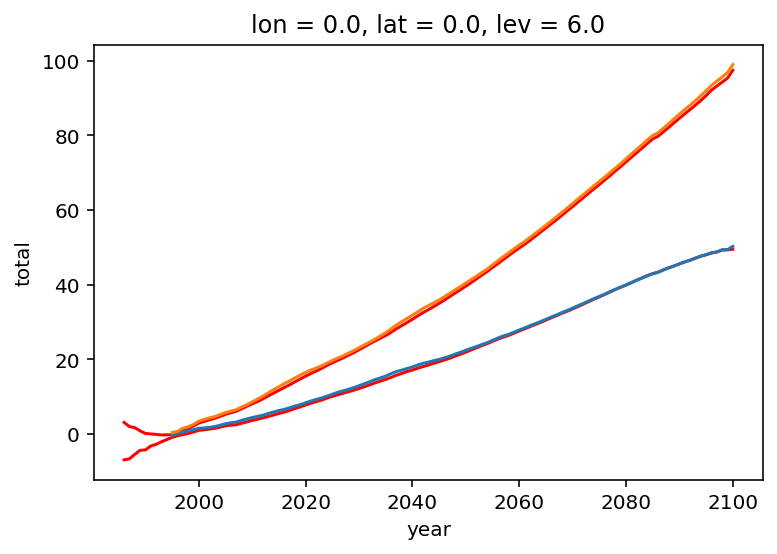

In [26]:
(KNMI14_high_ds.total[:,1]*100).plot(color='red')
(KNMI14_high_ds.total[:,5]*100).plot(color='red')
KNMI14_df['high_05'].plot()
KNMI14_df['high_95'].plot()

The total in  the budget method is not exactly the same as the csv data provided by Hylke but close enough.

In [27]:
def KNMI14_ds2df(ds,level=3):
    '''Extract the time series of contributors from a sea level projection 
    xarray dataset and build a pandas dataframe. Inputs are a dataset and 
    the percentile to extract.
    Info on the "level" index: 
    0:mean, 1:p05, 2:p10, 3:p50, 4:p90, 5:p95, 6:not used.
    '''
    variables = ['total', 'smb_gre', 'smb_aa', 'gic', 'ibe', 'steric', 
                 'dyn_gre', 'dyn_aa', 'groundw','tglob']
    
    df = pd.DataFrame()
    for idx, val in enumerate(variables):
        if val == 'tglob':
            df[val] = ds[val][:,0,0,0]
        else:
            df[val] = ds[val][:,level,0,0]*100 # Convert from m to cm

    df['time'] = ds.time
    df = df.set_index('time')
    return df

KNMI14_high_df = KNMI14_ds2df(KNMI14_high_ds, 3)
KNMI14_low_df = KNMI14_ds2df(KNMI14_low_ds, 3)
KNMI14_high_df.iloc[:10]

,total,smb_gre,smb_aa,gic,ibe,steric,dyn_gre,dyn_aa,groundw,tglob
time,,,,,,,,,,
1986.0,-1.874014,0.043003,0.0,-1.040916,0.238453,-1.023174,-0.091380,0.0,0.000000,-0.100000
1987.0,-2.294882,0.042999,0.0,-0.776771,-0.197886,-0.947712,-0.087457,0.0,-0.328055,-0.088889
1988.0,-1.838575,0.043003,0.0,-0.759642,-0.064240,-0.601879,-0.083440,0.0,-0.372378,-0.077778
1989.0,-1.732066,0.042984,0.0,-0.692082,-0.053985,-0.569760,-0.079329,0.0,-0.379893,-0.066667
1990.0,-2.020517,0.042986,0.0,-0.665228,-0.001086,-0.949826,-0.075124,0.0,-0.372239,-0.055556
1991.0,-1.561062,0.042993,0.0,-0.489643,0.104361,-0.790257,-0.070825,0.0,-0.357691,-0.044444
1992.0,-1.397392,0.043005,0.0,-0.383522,0.133858,-0.784798,-0.066432,0.0,-0.339503,-0.033333
1993.0,-1.140384,0.043002,0.0,-0.278797,0.105404,-0.629065,-0.061945,0.0,-0.318983,-0.022222
1994.0,-0.814100,0.043008,0.0,-0.157609,0.070268,-0.415907,-0.057365,0.0,-0.296496,-0.011111


Compare the KNMI14 and CMIP5 temperature pathways:

In [28]:
ROOT = '/Users/dewilebars/Projects/Project_ProbSLR/Data_Proj/'
DIR_T = ROOT+'Data_AR5/Tglobal/'
MOD = ["ACCESS1-0","BCC-CSM1-1","CanESM2","CNRM-CM5","CSIRO-Mk3-6-0","GFDL-ESM2G", \
    "GFDL-ESM2M","GISS-E2-R","HadGEM2-CC","HadGEM2-ES","inmcm4","IPSL-CM5A-LR", \
    "IPSL-CM5A-MR","MIROC5","MIROC-ESM-CHEM","MIROC-ESM","MPI-ESM-LR","MPI-ESM-MR", \
    "MRI-CGCM3","NorESM1-ME","NorESM1-M"]
N = int(1e5)
start_date = 1980    # Start reading data
ys = 2006   # Starting point for the integration, if this is changed problems in functions
ye = 2100   # End year for computation
nb_y = ye-start_date+1
TIME       = np.arange( start_date, ye + 1 )
#SCE = 'rcp85'
NormD  = np.random.normal(0, 1, N)
GAM = 1

Td_50p_df= pd.DataFrame({'time': np.arange(ys,ye+1)})
for SCE in ('rcp45', 'rcp85'):
    files = misc.temp_path_AR5(MOD, DIR_T, SCE)
    TGLOB = misc.tglob_cmip5(files, SCE, start_date, ye, LowPass=False, INFO=False)
    TGLOBs = TGLOB.sel(time=slice(ys,None))
    Tref = TGLOBs - TGLOB.sel(time=slice(1986,2005)).mean(dim='time')
    Td = misc.normal_distrib(Tref, 1, NormD)
    Td_50p = np.percentile(Td, 50, axis=0)
    Td_50p_df[SCE] = Td_50p
    
Td_50p_df = Td_50p_df.set_index('time')
Td_50p_df.plot()

KNMI14_high_df = KNMI14_high_df.rename(columns={'tglob': 'KNMI14 high'})
KNMI14_low_df = KNMI14_low_df.rename(columns={'tglob': 'KNMI14 low'})
KNMI14_high_df['KNMI14 high'].plot(legend=True,color='red')
KNMI14_low_df['KNMI14 low'].plot(legend=True)

#plt.savefig(path_report+'Tglob_path.pdf', dpi=150)
#plt.savefig('/Users/dewilebars/Documents/ConferencesLecturesTalks/2020_07_09_Vakgroepmeeting/Tglob_path.pdf', dpi=150)

TypeError: temp_path_AR5() takes 2 positional arguments but 3 were given

In [27]:
# Export data for Fedor
#temp_df = pd.concat([KNMI14_high_df['KNMI14 high'], KNMI14_low_df['KNMI14 low'], Td_50p_df ], axis=1, join='outer')
#temp_df.to_csv('../outputs/GlobalTemperatureKNMI14_rcp.csv')

There is a clear difference between the KNMI14 and the RCP temperature scenarios. With the high scenario temperature starting higher than RCP8.5 but then accelerating slower.

This leaves the question of the quick SLR in the low scenario open...

### How good were the KNMI'14 projections?
I first look into the Antarctic contribution

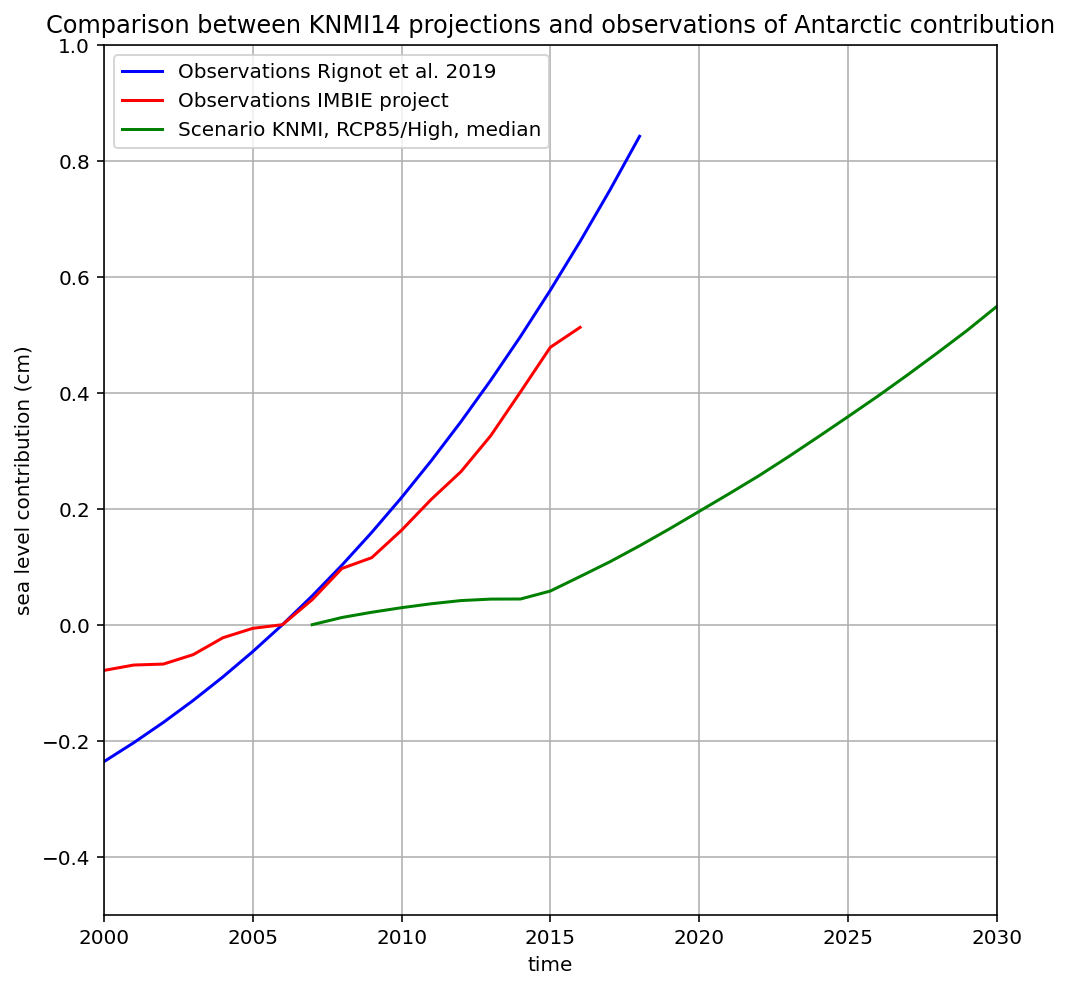

In [39]:
tg_id = [20, 22, 23, 24, 25, 32]
ant_rig_df = slc.ant_rignot19() * slc.ices_fp([tg_id[0]] , 'mit_unif', 
                                              'ant') #imbie or rignot19
ant_imb_df = slc.ant_imbie18() * slc.ices_fp([tg_id[0]] , 'mit_unif', 
                                              'ant') #imbie or rignot19

#Plot time series
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(ant_rig_df - ant_rig_df.loc[2006], 'b-', label='Observations Rignot et al. 2019')
ax.plot(ant_imb_df - ant_imb_df.loc[2006], 'r-', label='Observations IMBIE project')
plt.plot(KNMI14_85_ds.time[1:], KNMI14_85_ds.perc_ts[-2,5,1:] 
        - KNMI14_85_ds.perc_ts[-2,5,1], 'g-', 
        label='Scenario KNMI, RCP85/High, median')

ax.set_xlim([2000,2030])
ax.set_ylim([-0.5,1])
plt.xlabel('time')
plt.ylabel('sea level contribution (cm)')
plt.title('Comparison between KNMI14 projections and '+ 
          'observations of Antarctic contribution')
ax.grid(True)
plt.legend(loc='upper left')

#plt.savefig(path_report+'CompAntarcticTot_KNMI14_Obs.pdf', dpi=150)

In [40]:
# Graph of comparison between the observations and projections
# Read sea level budget for the North Sea
# Without LocSteric/GloSteric separation
#budget_df = pd.read_csv(path_slb+'SLBudget_Steric4000m_ERA5_1979_2018.csv')
# With LocSteric/GloSteric separation
# budget_df = pd.read_csv(path_slb+
#                         'SLBudget_Steric4000m_ERA5_1979_2018_withLocSteric.csv')
budget_df = pd.read_csv(path_slb+
                        'slbudget_2020_12_03_ZSM_1979_2018_ERA5StericEN4_4000m.csv')
# Former budget: 'slbudget_2020_07_08_ZSM_1979_2018_ERA5.csv'
# New budget: 'slbudget_2020_12_03_ZSM_1979_2018_ERA5StericEN4_4000m.csv'
budget_df = budget_df.set_index('time')
budget_df.iloc[-10:]


,Total,LocSteric,GloSteric,GIA,Glaciers,Antarctica,Greenland,TWS,Nodal,Wind,Pressure,Obs
time,,,,,,,,,,,,
2009,8.016171,3.552064,2.508173,1.105000,1.194167,0.370833,0.088333,0.188333,0.892339,-1.090116,-0.792955,5.600000
2010,8.003000,4.389224,2.463398,1.141833,1.259167,0.446667,0.100833,0.367500,0.735257,-2.354945,-0.545934,4.766667
2011,9.988545,4.781370,2.577349,1.178667,1.286667,0.466667,0.103333,-0.016667,0.555900,1.935137,-2.879877,8.250000
2012,7.799622,2.654583,2.741227,1.215500,1.289167,0.491667,0.115833,0.316667,0.374518,0.184546,-1.584085,7.300000
2013,5.084063,3.520389,2.934533,1.252333,1.345833,0.561667,0.125000,0.511667,0.211591,-3.656733,-1.722219,4.800000
2014,8.918411,4.540554,3.090276,1.289167,1.401667,0.626667,0.130833,0.240000,0.085516,-2.865864,0.379595,8.900000
2015,10.947002,3.255820,3.297743,1.326000,1.474167,0.721667,0.144167,0.465000,0.010529,3.470097,-3.218186,11.483333
2016,7.910991,3.790802,3.270519,1.362833,1.528333,0.692500,0.157500,0.675000,-0.004905,-1.330948,-2.230644,9.933333
2017,13.661746,5.137556,3.428105,1.399667,1.600000,0.708333,0.165000,0.130833,0.040957,3.277656,-2.226363,13.450000


<AxesSubplot:xlabel='time'>

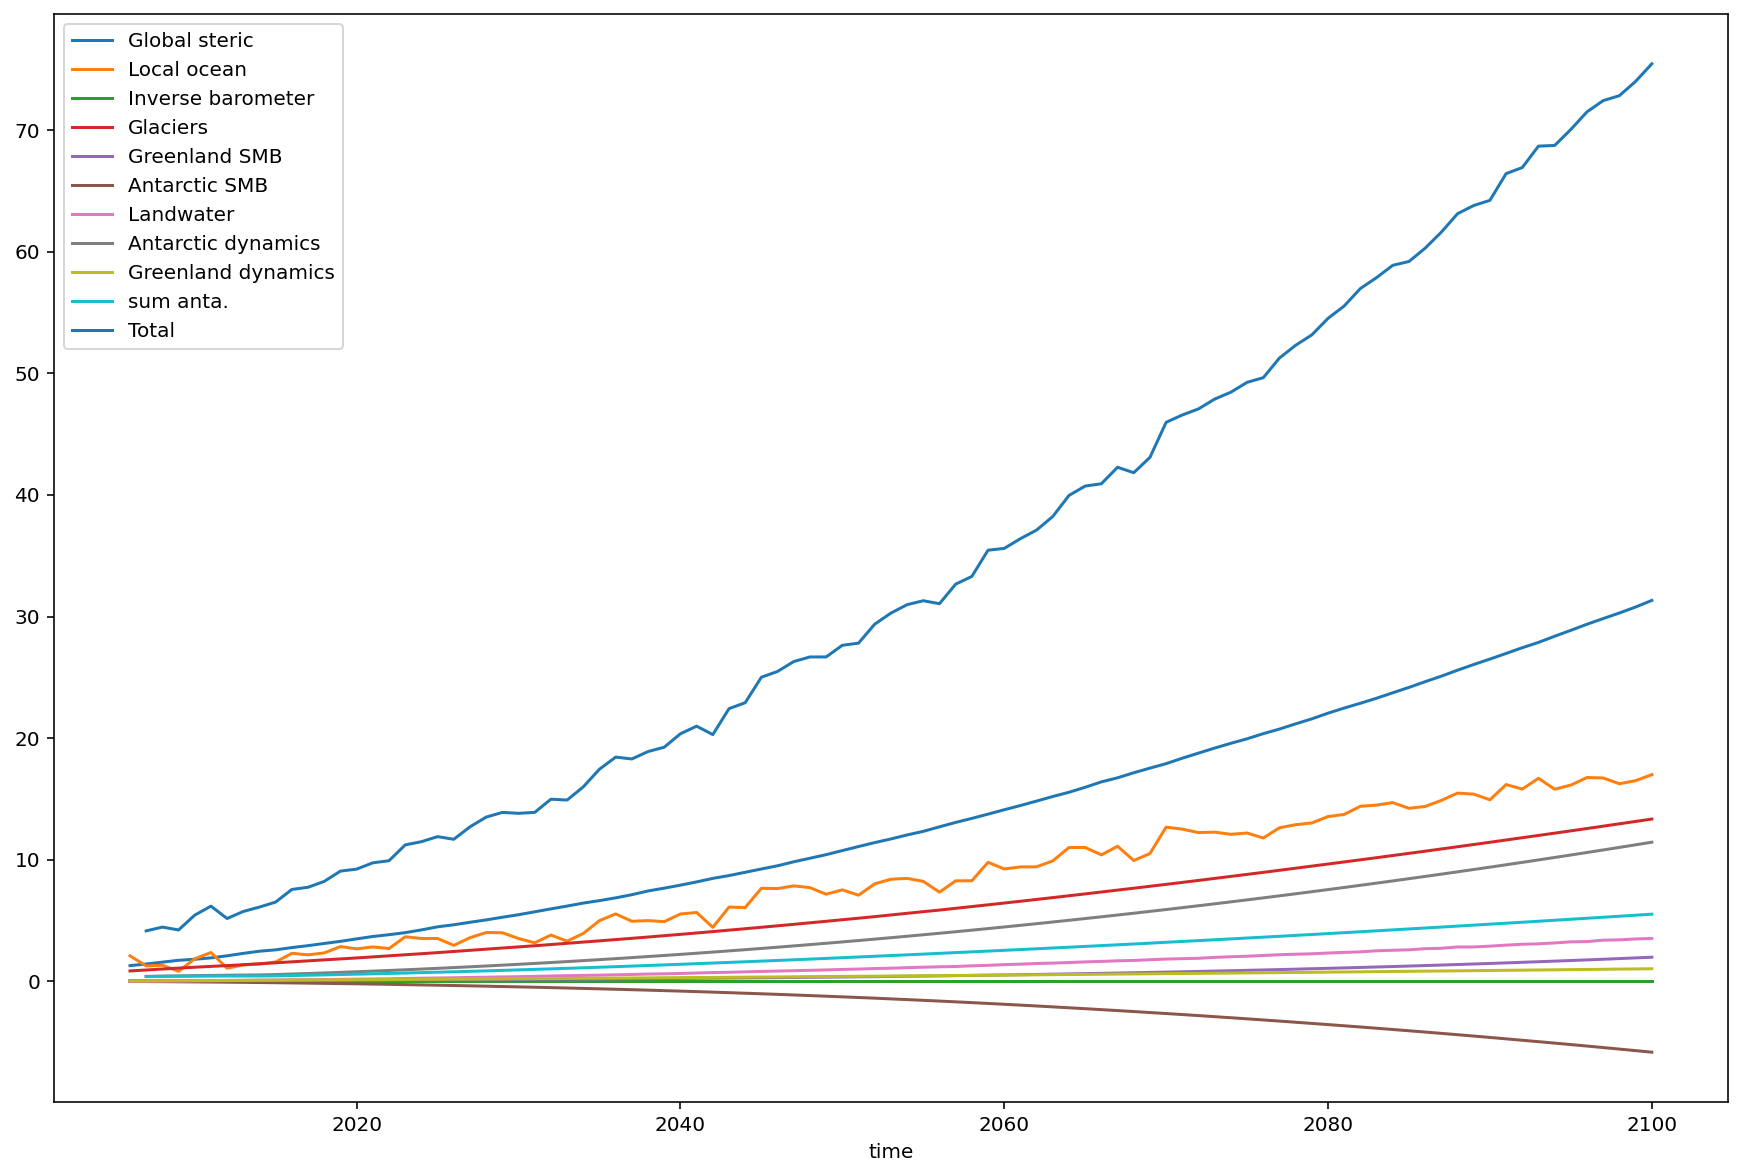

In [57]:
KNMI14_85_df = ds2df(KNMI14_85_ds,5) #1: 5p, 3: 50p 
KNMI14_45_df = ds2df(KNMI14_45_ds,5)
KNMI14_85_df.plot(figsize=[15,10])

In [58]:
#KNMI14_45_ds.MAT_RES.sel(percentiles=50, proc='Greenland dynamics').plot()
KNMI14_45_ds.perc_ts.sel(percentiles=50, proc='Greenland dynamics')

<xarray.DataArray 'perc_ts' (time: 95)>
array([0.03313 , 0.039742, 0.046441, 0.053229, 0.060103, 0.067066, 0.074115,
       0.081253, 0.088477, 0.09579 , 0.10319 , 0.110677, 0.118252, 0.125914,
       0.133664, 0.141502, 0.149427, 0.157439, 0.16554 , 0.173727, 0.182002,
       0.190365, 0.198815, 0.207353, 0.215978, 0.224691, 0.233491, 0.242379,
       0.251354, 0.260417, 0.269568, 0.278805, 0.288131, 0.297544, 0.307044,
       0.316632, 0.326308, 0.336071, 0.345922, 0.35586 , 0.365885, 0.375999,
       0.386199, 0.396488, 0.406863, 0.417327, 0.427877, 0.438516, 0.449242,
       0.460055, 0.470956, 0.481944, 0.49302 , 0.504184, 0.515435, 0.526774,
       0.5382  , 0.549713, 0.561314, 0.573003, 0.584779, 0.596643, 0.608594,
       0.620633, 0.632759, 0.644973, 0.657274, 0.669663, 0.68214 , 0.694704,
       0.707355, 0.720094, 0.732921, 0.745835, 0.758836, 0.771925, 0.785102,
       0.798366, 0.811718, 0.825157, 0.838684, 0.852298, 0.866   , 0.879789,
       0.893666, 0.90763 , 0.921682, 0.935822, 0.950048, 0.964363, 0.978765,
       0.993254, 1.007832, 1.022496, 1.037248])
Coordinates:
    proc         <U18 'Greenland dynamics'
    percentiles  int64 50
  * time         (time) int64 2006 2007 2008 2009 2010 ... 2097 2098 2099 2100
Attributes:
    units:      cm
    long_name:  Time series of percentiles.

In [59]:
KNMI14_45_ds.perc_ts.sel(proc='Global steric', percentiles=50, time=slice(2006,2018) ).mean()

<xarray.DataArray 'perc_ts' ()>
array(2.10324356)
Coordinates:
    proc         <U13 'Global steric'
    percentiles  int64 50

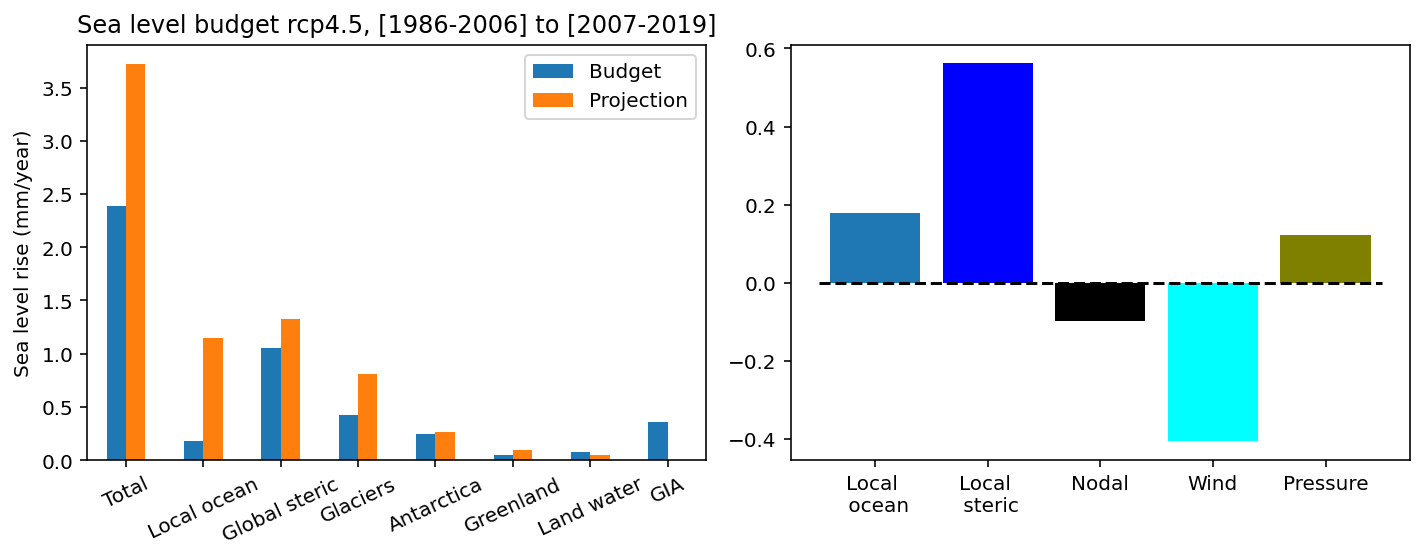

In [60]:
sp = 2007
ep = 2019
ref_s = 1986
ref_e = 2006
tot_years = (sp+ep)/2 - (ref_e+ref_s)/2

KNMI14_rcp_diff = KNMI14_45_df.loc[sp:ep].mean()/tot_years*10 # To use a time period
#KNMI14_rcp_diff = KNMI14_45_df.loc[(sp+ep)/2]/tot_years*10

budget_diff = (budget_df.loc[sp:ep].mean() - budget_df.loc[ref_s:ref_e].mean())/tot_years*10

# Build a new dataframe for comparison purposes:
index = ['Total', 'Local ocean', 'Global steric', 'Glaciers', 'Antarctica', 
         'Greenland', 'Land water', 'GIA']
budget_LocOcean = budget_diff['LocSteric'] + budget_diff['Nodal'] \
+ budget_diff['Wind'] +  budget_diff['Pressure']
obs_budget = [budget_diff['Total'], budget_LocOcean, budget_diff['GloSteric'],
              budget_diff['Glaciers'], budget_diff['Antarctica'], 
              budget_diff['Greenland'], budget_diff['TWS'], budget_diff['GIA']] 
proj = [KNMI14_rcp_diff['Total'], KNMI14_rcp_diff['Local ocean'], 
         KNMI14_rcp_diff['Global steric'], KNMI14_rcp_diff['Glaciers'],
         KNMI14_rcp_diff['sum anta.'], 
         KNMI14_rcp_diff['Greenland SMB'] + KNMI14_rcp_diff['Greenland dynamics'],
         KNMI14_rcp_diff['Landwater'],  0]
comp_df = pd.DataFrame({'Budget': obs_budget,
                   'Projection': proj}, index=index)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
comp_df.plot.bar(ax=ax[0], rot=25)

index = ['Local \n ocean', 'Local \n steric', 'Nodal', 'Wind', 'Pressure']
obs_loc_ocean = [budget_LocOcean, budget_diff['LocSteric'], budget_diff['Nodal'], 
                 budget_diff['Wind'], budget_diff['Pressure']]
obs_loc_ocean_df = pd.DataFrame({'Decomp. Local ocean': obs_loc_ocean} , index=index)

colors = ['tab:blue', 'blue', 'black', 'cyan', 'olive']
#obs_loc_ocean_df.plot.bar(ax=ax[1], rot=25, color=colors)
ax[1].bar(index, obs_loc_ocean, color=colors)
ax[1].hlines(y=0, xmin=-0.5, xmax=4.5, color='black', linestyles='dashed')

ax[0].set_ylabel('Sea level rise (mm/year)')
ax[0].set_title('Sea level budget rcp4.5, ['+str(ref_s)+'-'+str(ref_e)+']'+' to ['+str(sp)+'-'+str(ep)+']' )
plt.tight_layout()

plt.savefig('../figures/Comp_Budget_rcp45_more_details.pdf', dpi=150)

In [61]:
comp_df['Diff'] = comp_df['Projection'] - comp_df['Budget']
comp_df

,Budget,Projection,Diff
Total,2.390519,3.717065,1.326546
Local ocean,0.179079,1.144427,0.965348
Global steric,1.051588,1.323239,0.271651
Glaciers,0.428175,0.807251,0.379076
Antarctica,0.246965,0.267382,0.020417
Greenland,0.051196,0.095454,0.044258
Land water,0.076015,0.046831,-0.029184
GIA,0.357500,0.000000,-0.357500


In [62]:
obs_loc_ocean_df = pd.DataFrame({index[0]:obs_loc_ocean[0],  index[1]:obs_loc_ocean[1],
                                index[2]:obs_loc_ocean[2],  index[3]:obs_loc_ocean[3],
                                index[4]:obs_loc_ocean[4]}, index=[0])
obs_loc_ocean_df

,Local \n ocean,Local \n steric,Nodal,Wind,Pressure
0,0.179079,0.561428,-0.098166,-0.405715,0.121533


<AxesSubplot:xlabel='time'>

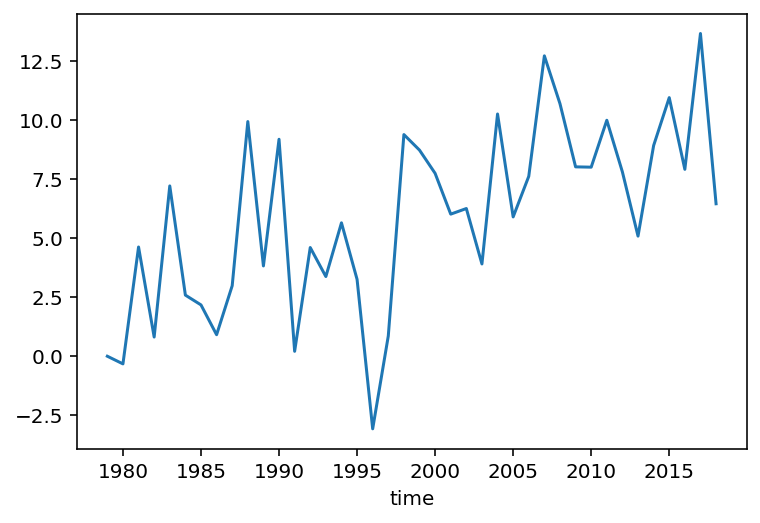

In [63]:
budget_df.Total.plot()

It is strange that the 'Local ocean' term of the projections is so similar for the RCP45 and RCP85 scenarios.

Now we compare the components without separating the local ocean and global steric terms to be able to include KNMI'14 projections as well.

Text(0.5, 1.0, 'Sea level budget, [1986-2006] to [2007-2019]')

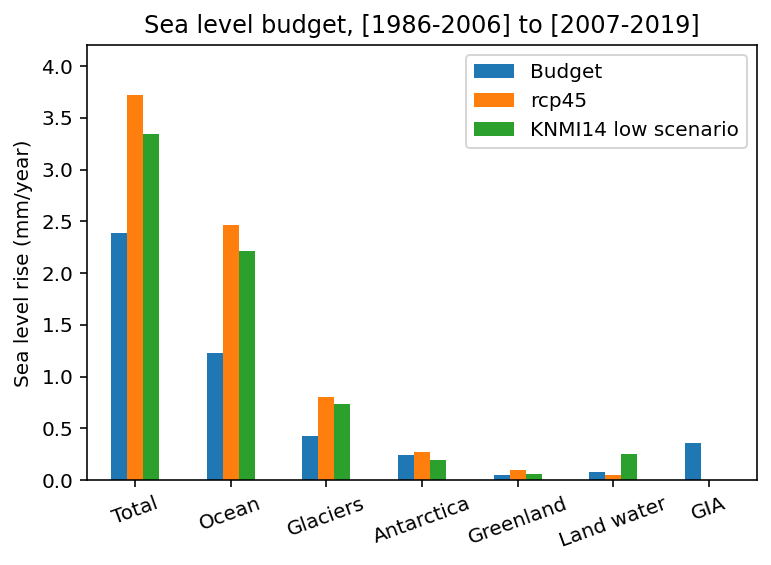

In [64]:
sce = 'low' # 'low' or 'high'
if sce == 'low':
    KNMI14_sce = KNMI14_low_df
    rcp_scen = 'rcp45'
    KNMI14_rcp = KNMI14_45_df
elif sce == 'high':
    KNMI14_sce = KNMI14_high_df
    rcp_scen = 'rcp85'
    KNMI14_rcp = KNMI14_85_df

#KNMI14_rcp_diff = KNMI14_rcp.loc[(sp+ep)/2]/tot_years*10
#KNMI14_rcp_diff = KNMI14_rcp.loc[(sp+ep)/2-2:(sp+ep)/2+2].mean()/tot_years*10
KNMI14_rcp_diff = KNMI14_rcp.loc[sp:ep].mean()/tot_years*10
KNMI14_sce_diff = (KNMI14_sce.loc[(sp+ep)/2] #.mean() 
                   - KNMI14_sce.loc[ref_s:ref_e].mean())/tot_years*10

# Build a new dataframe for comparison purposes:
index = ['Total', 'Ocean', 'Glaciers', 'Antarctica', 
         'Greenland', 'Land water', 'GIA']

obs_budget = [budget_diff['Total'], budget_LocOcean + budget_diff['GloSteric'],
              budget_diff['Glaciers'], budget_diff['Antarctica'], 
              budget_diff['Greenland'], budget_diff['TWS'], budget_diff['GIA']]
proj = [KNMI14_rcp_diff['Total'], KNMI14_rcp_diff['Local ocean'] 
        + KNMI14_rcp_diff['Global steric'], KNMI14_rcp_diff['Glaciers'],
         KNMI14_rcp_diff['sum anta.'], 
         KNMI14_rcp_diff['Greenland SMB'] + KNMI14_rcp_diff['Greenland dynamics'],
         KNMI14_rcp_diff['Landwater'],  0]
sce_proj = [KNMI14_sce_diff['total'], KNMI14_sce_diff['steric'], 
            KNMI14_sce_diff['gic'], 
            KNMI14_sce_diff['smb_aa'] + KNMI14_sce_diff['dyn_aa'],
            KNMI14_sce_diff['smb_gre'] + KNMI14_sce_diff['dyn_gre'],
            KNMI14_sce_diff['groundw'], 0]
comp_df = pd.DataFrame({'Budget': obs_budget,
                        rcp_scen: proj, 
                        'KNMI14 '+sce+' scenario': sce_proj},
                       index=index)

ax = comp_df.plot.bar(rot=20)
ax.set_ylim([0,4.2])
plt.ylabel('Sea level rise (mm/year)')
plt.title('Sea level budget, ['+str(ref_s)+'-'+str(ref_e)+']'+' to ['+str(sp)+'-'+str(ep)+']' )

#plt.savefig('../figures/Comp_Budget_KNMI14low_rcp45.pdf', dpi=150)


In [65]:
KNMI14_rcp = KNMI14_85_df
KNMI14_rcp_diff = KNMI14_rcp.loc[(sp+ep)/2]/tot_years*10
KNMI14_rcp_diff

Global steric         1.353696
Local ocean           0.796553
Inverse barometer     0.000000
Glaciers              0.805014
Greenland SMB         0.046652
Antarctic SMB        -0.048665
Landwater             0.044230
Antarctic dynamics    0.304978
Greenland dynamics    0.047792
sum anta.             0.257751
Total                 3.381446
Name: 2013, dtype: float64

In [66]:
KNMI14_85_df.loc[:2020]

,Global steric,Local ocean,Inverse barometer,Glaciers,Greenland SMB,Antarctic SMB,Landwater,Antarctic dynamics,Greenland dynamics,sum anta.,Total
time,,,,,,,,,,,
2006,1.292516,2.100625,0.0,0.855921,0.062221,-0.007922,0.000000,inf,0.033130,inf,inf
2007,1.425550,1.268357,0.0,0.932766,0.064161,-0.015901,0.008784,0.410830,0.039741,0.394063,4.149305
2008,1.579363,1.323862,0.0,1.012792,0.066432,-0.025689,0.018086,0.432179,0.046440,0.406488,4.461451
2009,1.731348,0.828448,0.0,1.088293,0.068815,-0.036088,0.028208,0.452151,0.053226,0.415477,4.226608
2010,1.816403,1.852488,0.0,1.161451,0.071314,-0.047090,0.038913,0.470761,0.060100,0.423344,5.445432
2011,1.929695,2.371620,0.0,1.230644,0.073855,-0.058293,0.050173,0.488015,0.067061,0.430156,6.183820
2012,2.100972,1.081373,0.0,1.295883,0.076396,-0.069553,0.062095,0.503915,0.074110,0.435639,5.166355
2013,2.301283,1.354140,0.0,1.368523,0.079308,-0.082731,0.075191,0.518462,0.081246,0.438177,5.748457
2014,2.478079,1.424360,0.0,1.446674,0.082559,-0.097542,0.089014,0.531657,0.088470,0.438361,6.109471


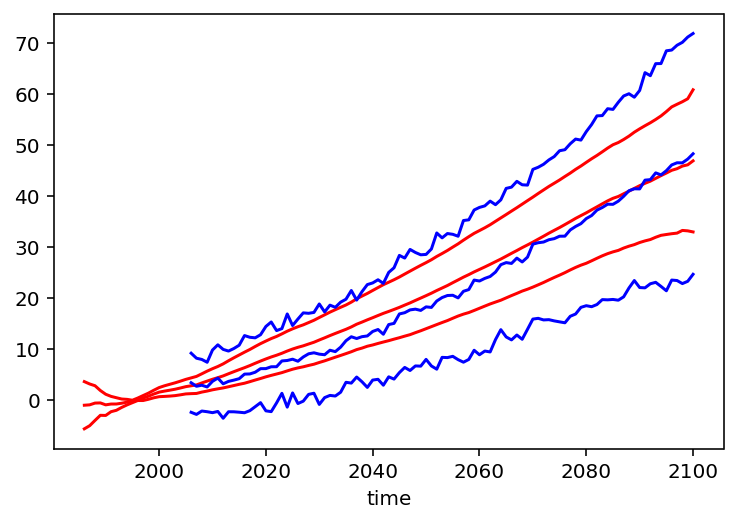

In [74]:
for quant in [1,3,5]:
    ocn_KNMI14 = KNMI14_ds2df(KNMI14_high_ds, quant)['steric']
    ocn_KNMI14 = ocn_KNMI14 #- ocn_KNMI14.loc[1986:2006].mean()
    ocn_KNMI14.plot(color='red')
    
for quant in [1,5,9]:
    KNMI14_85_df = ds2df(KNMI14_85_ds,quant)
    ocn_rcp = KNMI14_85_df['Global steric'] + KNMI14_85_df['Local ocean']
    ocn_rcp.plot(color='blue')
    
    #ocn_KNMI14.plot(xlim=[1980,2020], ylim=[-10,20])


In [75]:
KNMI14_high_ds

<xarray.Dataset>
Dimensions:  (lat: 1, lev: 7, lon: 1, time: 115)
Coordinates:
  * time     (time) float64 1.986e+03 1.987e+03 1.988e+03 ... 2.099e+03 2.1e+03
  * lon      (lon) float64 0.0
  * lat      (lat) float64 0.0
  * lev      (lev) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0
Data variables:
    groundw  (time, lev, lat, lon) float32 0.0 0.0 0.0 ... 0.0805 0.0009787
    dyn_aa   (time, lev, lat, lon) float32 0.0 0.0 0.0 ... 0.3359 0.002785
    dyn_gre  (time, lev, lat, lon) float32 -0.0009137 -0.001027 ... 0.0001905
    steric   (time, lev, lat, lon) float32 -0.01023 -0.05657 ... 0.6088 0.01898
    ibe      (time, lev, lat, lon) float32 0.002385 -0.01369 ... 0.005641
    gic      (time, lev, lat, lon) float32 -0.01041 -0.02067 ... 0.1571 0.002546
    smb_aa   (time, lev, lat, lon) float32 0.0 0.0 0.0 ... -0.02683 0.001227
    smb_gre  (time, lev, lat, lon) float32 0.0004663 0.0002221 ... 0.0003524
    cmip5    (time, lev, lat, lon) float32 -0.01779 -0.06259 ... 0.6997 0.0
    total    (time, lev, lat, lon) float32 -0.0187 -0.06885 ... 0.9744 0.02022
    distr    (time, lev, lat, lon) float32 -0.0187 -0.06455 ... 0.9855 0.02022
    tglob    (time, lev, lat, lon) float32 -0.1 9.969e+36 ... 9.969e+36
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Mon Mar 23 10:55:18 2020: cdo -ensmean 001_knmi_NORTHSEA_sl...
    CDO:          Climate Data Operators version 1.9.8 (https://mpimet.mpg.de...

<AxesSubplot:xlabel='time'>

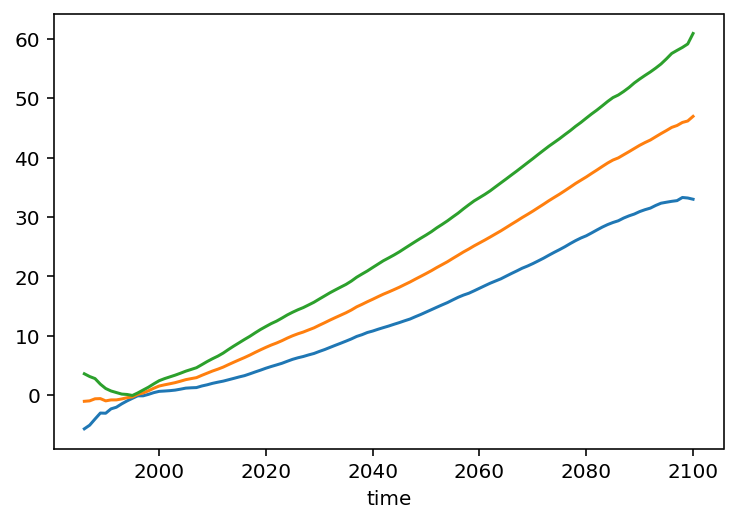

In [76]:
ocn_KNMI14_p5 = KNMI14_ds2df(KNMI14_high_ds, 1)['steric']
#ocn_KNMI14_p5 = ocn_KNMI14_p5 - ocn_KNMI14_p5.loc[1986:2006].mean()
ocn_KNMI14_p5.plot()

ocn_KNMI14_p50 = KNMI14_ds2df(KNMI14_high_ds, 3)['steric']
#ocn_KNMI14_p50 = ocn_KNMI14_p50 - ocn_KNMI14_p50.loc[1986:2006].mean()
ocn_KNMI14_p50.plot()

ocn_KNMI14_p95 = KNMI14_ds2df(KNMI14_high_ds, 5)['steric']
#ocn_KNMI14_p95 = ocn_KNMI14_p95 - ocn_KNMI14_p95.loc[1986:2006].mean()
ocn_KNMI14_p95.plot()

In [77]:
KNMI14_sce_diff

total         3.347926
smb_gre       0.005727
smb_aa       -0.037966
gic           0.734068
ibe          -0.110117
steric        2.218159
dyn_gre       0.052858
dyn_aa        0.230068
groundw       0.255129
KNMI14 low    0.172906
dtype: float32

### Removing natural variability

Let us now look at the comparison while removing some natural variability effects from the observations: wind, pressure and nodal cycle

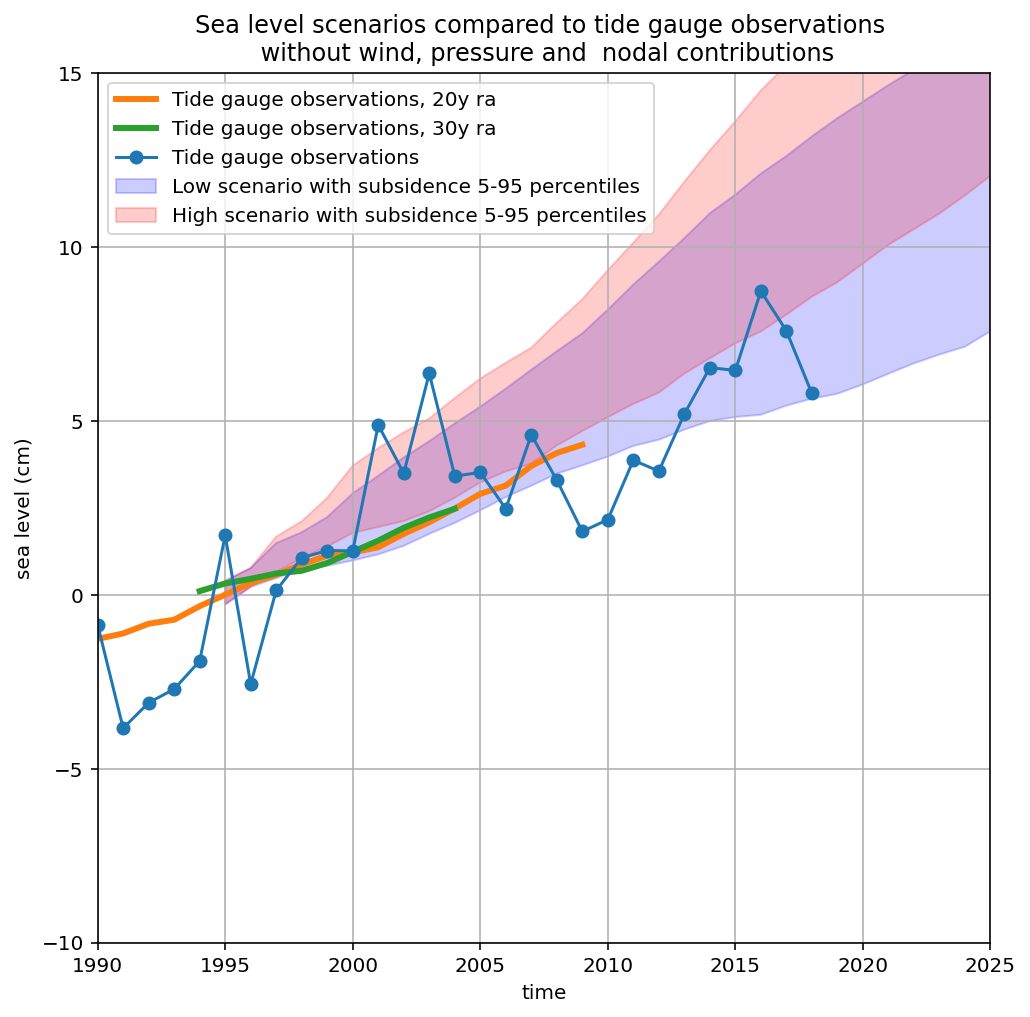

In [78]:
NatVar_df = budget_df['Wind'] + budget_df['Nodal'] + budget_df['Pressure']
tg_noNatVar_df = budget_df['Obs'] - NatVar_df
tg_avg_20ra = tg_noNatVar_df.rolling(20, center=True).mean()
tg_avg_30ra = tg_noNatVar_df.rolling(30, center=True).mean()
ref = tg_avg_20ra.loc[1995]

#Plot time series
fig, ax = plt.subplots(figsize=(8,8))
ax.fill_between(KNMI14_df.index, KNMI14_df['low_05_sub'], 
                KNMI14_df['low_95_sub'], color='blue',alpha=0.2,
               label='Low scenario with subsidence 5-95 percentiles')
ax.fill_between(KNMI14_df.index, KNMI14_df['high_05_sub'], 
                KNMI14_df['high_95_sub'], color='red',alpha=0.2,
               label='High scenario with subsidence 5-95 percentiles')

ax.plot(tg_avg_20ra - ref, '-', color='tab:orange', label='Tide gauge observations, 20y ra', linewidth=3)
ax.plot(tg_avg_30ra - ref, '-', color='tab:green', label='Tide gauge observations, 30y ra', linewidth=3)
ax.plot(tg_noNatVar_df - ref, 'o-', color='tab:blue', label='Tide gauge observations')

#ax.set_aspect(1)
#ax.set_xlim([1950,2030])
#ax.set_ylim([-5,35])
ax.set_xlim([1990,2025])
ax.set_ylim([-10,15])
plt.xlabel('time')
plt.ylabel('sea level (cm)')
plt.title('Sea level scenarios compared to tide gauge observations \n without wind, pressure and  nodal contributions')
ax.grid(True)
plt.legend(loc='upper left')

#plt.savefig(path_report+'Comp_noNatVar.pdf', dpi=150)
plt.savefig('/Users/dewilebars/Documents/ConferencesLecturesTalks/2020_07_09_Vakgroepmeeting/KNMI14vsTG_noNatVar.pdf', dpi=150)

Comments:

It looks like the choice of the length of the running average window is very important for the comparison between projections and observations. For some reason 30 years ends up in a higher starting position in 1995 and therefore gives a worst match compared to 20 years.

This also holds for the time series from which wind effects are removed.

<AxesSubplot:xlabel='time'>

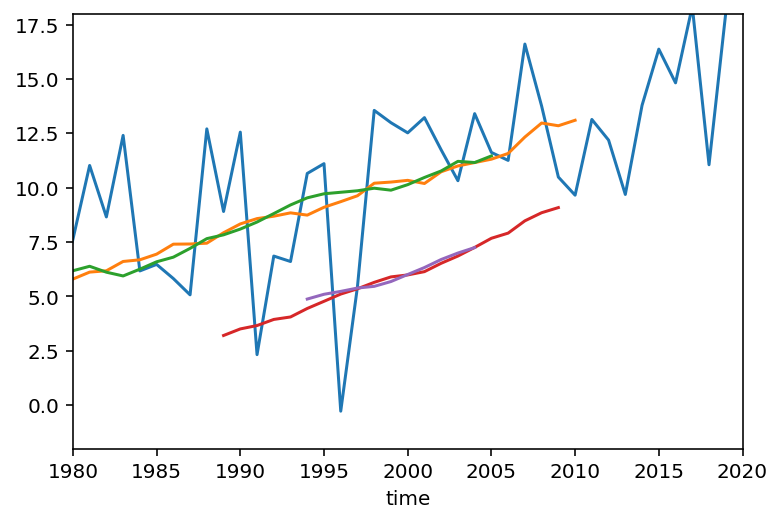

In [79]:
tg_avg_ra20 = tg_df['Average'].rolling(20, center=True).mean()
tg_avg_ra30 = tg_df['Average'].rolling(30, center=True).mean()
tg_avg_ra20_noNatVar = tg_noNatVar_df.rolling(20, center=True).mean()
tg_avg_ra30_noNatVar = tg_noNatVar_df.rolling(30, center=True).mean()

ylimv = [-2,18]
tg_df['Average'].plot(xlim=[1980,2020], ylim=ylimv)
tg_avg_ra20.plot(xlim=[1980,2020], ylim=ylimv)
tg_avg_ra30.plot(xlim=[1980,2020], ylim=ylimv)
tg_avg_ra20_noNatVar.plot(xlim=[1980,2020], ylim=ylimv)
tg_avg_ra30_noNatVar.plot(xlim=[1980,2020], ylim=ylimv)